# Try to add a nifty model for sampling the input map

2.1.1


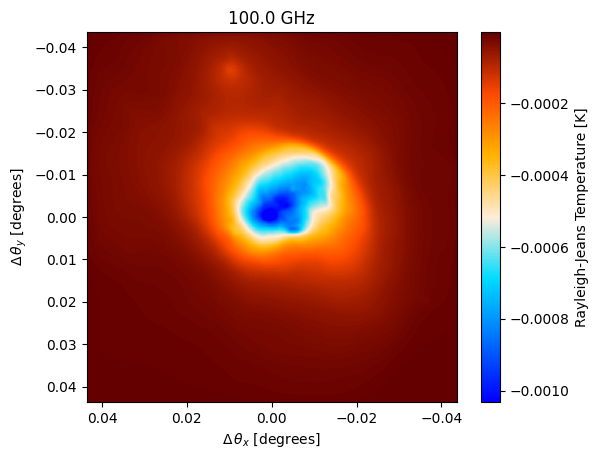

In [1]:
import scipy as sp
import numpy as np
print(np.__version__)
import matplotlib.pyplot as plt
import maria

import jax.numpy as jnp

map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=-8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

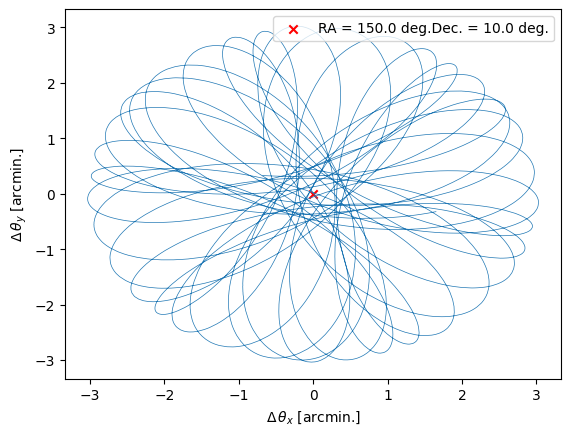

In [2]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

In [3]:
instrument = maria.get_instrument('MUSTANG-2')
# instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                                plan=plan,
                                site="llano_de_chajnantor", 
                                map=input_map,
                                # noise=False,
                                # atmosphere="2d",
                                # cmb="generate",
                                )

tod_truthmap = sim_truthmap.run()

2024-10-01 17:34:49.415 INFO: Constructed instrument.
2024-10-01 17:34:49.416 INFO: Constructed plan.
2024-10-01 17:34:49.418 INFO: Constructed site.
2024-10-01 17:34:50.065 INFO: Constructed boresight.
2024-10-01 17:34:50.491 INFO: Constructed offsets.


Initialized base in 1076 ms.


Sampling map (m2/f093): 100%|██████████| 1/1 [00:03<00:00,  3.33s/it]


In [4]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

dx

array([[-1.96604336e-04, -1.93090613e-04, -1.89470620e-04, ...,
         4.73482881e-04,  4.76764109e-04,  4.80085936e-04],
       [-2.45732167e-04, -2.42218725e-04, -2.38599011e-04, ...,
         4.28128111e-04,  4.31409053e-04,  4.34730605e-04],
       [-1.21415484e-04, -1.17901819e-04, -1.14281886e-04, ...,
         5.49360377e-04,  5.52641566e-04,  5.55963347e-04],
       ...,
       [ 1.21229486e-04,  1.24745513e-04,  1.28367793e-04, ...,
         7.60443498e-04,  7.63727048e-04,  7.67051118e-04],
       [-4.05092478e-04, -4.01576046e-04, -3.97953351e-04, ...,
         2.29301026e-04,  2.32584850e-04,  2.35909239e-04],
       [-7.45993108e-04, -7.42479600e-04, -7.38859809e-04, ...,
        -7.24916352e-05, -6.92107429e-05, -6.58891924e-05]])

Running mapper (m2/f093): 100%|██████████| 1/1 [00:05<00:00,  5.85s/it]


mapdata_truth shape: (1, 1000, 1000)
mapdata_truth mean: -8.726028151723567e-05


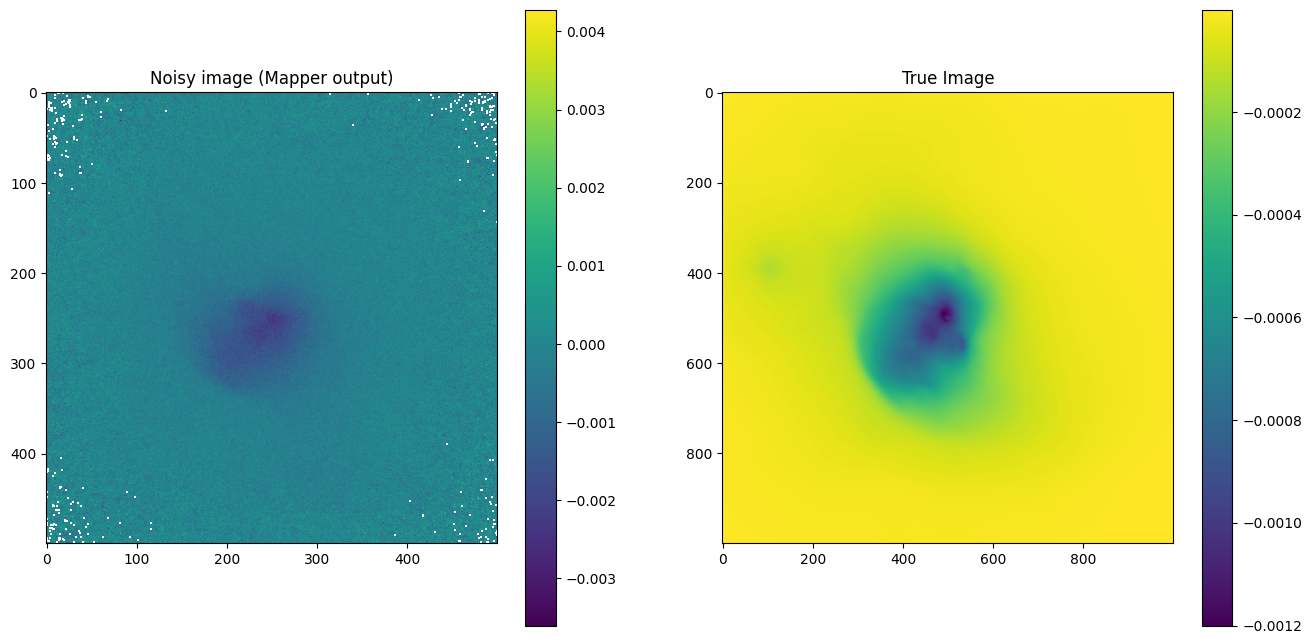

In [5]:
from maria.map.mappers import BinMapper

# Run mapper without any filtering to get noisy mimge
mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

print("mapdata_truth shape:", mapdata_truth.shape)
print("mapdata_truth mean:", mapdata_truth.mean())

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(output_truthmap.data[0].T)
fig.colorbar(im0)
axes[0].title.set_text("Noisy image (Mapper output)")

im1 = axes[1].imshow(mapdata_truth[0])
fig.colorbar(im1)
axes[1].title.set_text("True Image")

plt.show()

# Re-implement map sampling in JAX for nifty response function:

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import jax
import nifty8.re as jft
import matplotlib.pyplot as plt

from jax import random

seed = 42
key = random.PRNGKey(seed)

2024-10-01 17:35:03.702 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-10-01 17:35:03.704 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [7]:
# jax compatible rewrite if beams.separably_filter
@jax.jit
def separably_filter(data, F, tol=1e-2, return_filter=False):
    """
    This is more efficient than 2d convolution
    """

    assert data.ndim == 2

    u, s, v = jax.numpy.linalg.svd(F)
    effective_filter = 0
    filtered_image = 0

    # pad data array to achieve mirroring effect
    data = jax.numpy.column_stack([data[:,0], data, data[:, -1]]) # axis=1
    data = jax.numpy.vstack([data[0], data, data[-1]]) # axis=0

    for m in range(len(F)):
        effective_filter += s[m] * u[:, m : m + 1] @ v[m : m + 1]
        
        # Turn kernels into shape (1, dim) to work in nd function
        u_kernel = jax.numpy.broadcast_to(u[:, m], (1, u[:, m].size))
        v_kernel = jax.numpy.broadcast_to(u[:, m], (1, v[m].size))
        
        filtered_image += s[m] * jax.scipy.signal.convolve(jax.scipy.signal.convolve(data, u_kernel.T, mode='same'), v_kernel, mode='same')[1:-1, 1:-1]

    return (filtered_image, effective_filter) if return_filter else filtered_image

In [8]:
@jax.jit
def construct_beam_filter(fwhm, res, buffer=1):
    """
    Make a beam filter for an image.
    """

    # if beam_profile is None:
    #     # beam_profile = lambda r, r0: np.where(r <= r0, 1., 0.)

    #     # a top hat
    #     def beam_profile(r, r0):
    #         return np.exp(-((r / r0) ** 16))

    filter_width = buffer * fwhm

    # n_side = jax.numpy.maximum(filter_width / res, 3).astype(int) # n_side = 3

    filter_side = jax.numpy.linspace(-filter_width / 2, filter_width / 2, 3)
    X, Y = jax.numpy.meshgrid(filter_side, filter_side, indexing="ij")
    R = jax.numpy.sqrt(jax.numpy.square(X) + jax.numpy.square(Y))
    F = jax.numpy.exp(-((R / (fwhm / 2)) ** 16))

    return F / F.sum()

In [9]:
from maria.constants import k_B
from maria.instrument import beams

@jax.jit
def sample_maps(sim_truthmap, dx, dy, resolution, x_side, y_side):

    data_map = jax.numpy.array(1e-16 * np.random.standard_normal(size=dx.shape))
    pbar = instrument.bands

    for band in pbar:
        band_mask = instrument.dets.band_name == band.name

        nu = jax.numpy.linspace(band.nu_min, band.nu_max, 64)
        TRJ = jax.scipy.interpolate.RegularGridInterpolator(
            (jax.numpy.array([100.]),),
            sim_truthmap,
            fill_value=None,
            bounds_error=False,
            method='nearest',
        )(nu)


        nu_passband = jax.numpy.exp(jax.numpy.log(0.5) * (2 * (nu - 90.) / 30.) ** 2)
        power_map = (
            1e12
            * k_B
            * jax.numpy.trapezoid(nu_passband[:, None, None] * TRJ, axis=0, x=1e9 * nu)
        )

        # nu is in GHz, f is in Hz
        nu_fwhm = beams.compute_angular_fwhm(
            # fwhm_0=sim_truthmap.instrument.dets.primary_size.mean(),
            fwhm_0=instrument.dets.primary_size.mean(),
            z=np.inf,
            f=1e9 * band.center,
        ) 
        
        nu_map_filter = construct_beam_filter(fwhm=nu_fwhm, res=resolution)
        filtered_power_map = separably_filter(power_map, nu_map_filter)
        
        # jax:
        map_power = jax.scipy.interpolate.RegularGridInterpolator(
            # Need to invert x_side and y_side for jax interpolation:
            (jax.numpy.flip(x_side), jax.numpy.flip(y_side)), # length N=2 sequence of arrays with grid coords
            # jax.numpy.flip(sim_truthmap[0]),
            jax.numpy.flip(filtered_power_map), # N=2-dimensional array specifying grid values (1000, 1000)
            fill_value=0.,
            bounds_error=False,
            method="linear",
        )((jax.numpy.array(dx[band_mask]), jax.numpy.array(dy[band_mask])))

        # jax.debug.print("Total map power: {pwr}", pwr=map_power.sum())

        # data["map"][band_mask] += map_power
        data_map = data_map.at[band_mask].add(map_power)
        
    # return sim_truthmap.data["map"]
    return data_map

## Test TOD agreement for noise-free map

(200, 200)


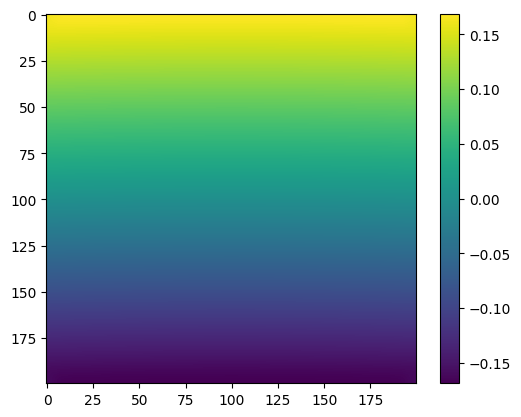

In [10]:
atmosdata_truth = np.float64(np.load('atmosphere.npy')[:, :, 0])

# pad img with average
# atmosdata_truth = np.pad(atmosdata_truth, pad_width=5, mode='constant', constant_values=atmosdata_truth.mean())

print(atmosdata_truth.shape)
plt.imshow(atmosdata_truth - atmosdata_truth.mean())
plt.colorbar()

In [11]:
# x_side = np.float64(np.linspace(-0.05, 0.05, 200))
# y_side = np.float64(np.linspace(-0.05, 0.05, 200))

x_side = np.float64(np.linspace(sim_truthmap.map.x_side.max()*2., sim_truthmap.map.x_side.min()*2., 200))
y_side = np.float64(np.linspace(sim_truthmap.map.y_side.max()*2., sim_truthmap.map.y_side.min()*2., 200)) # Ordering of x_side and y_side matters!

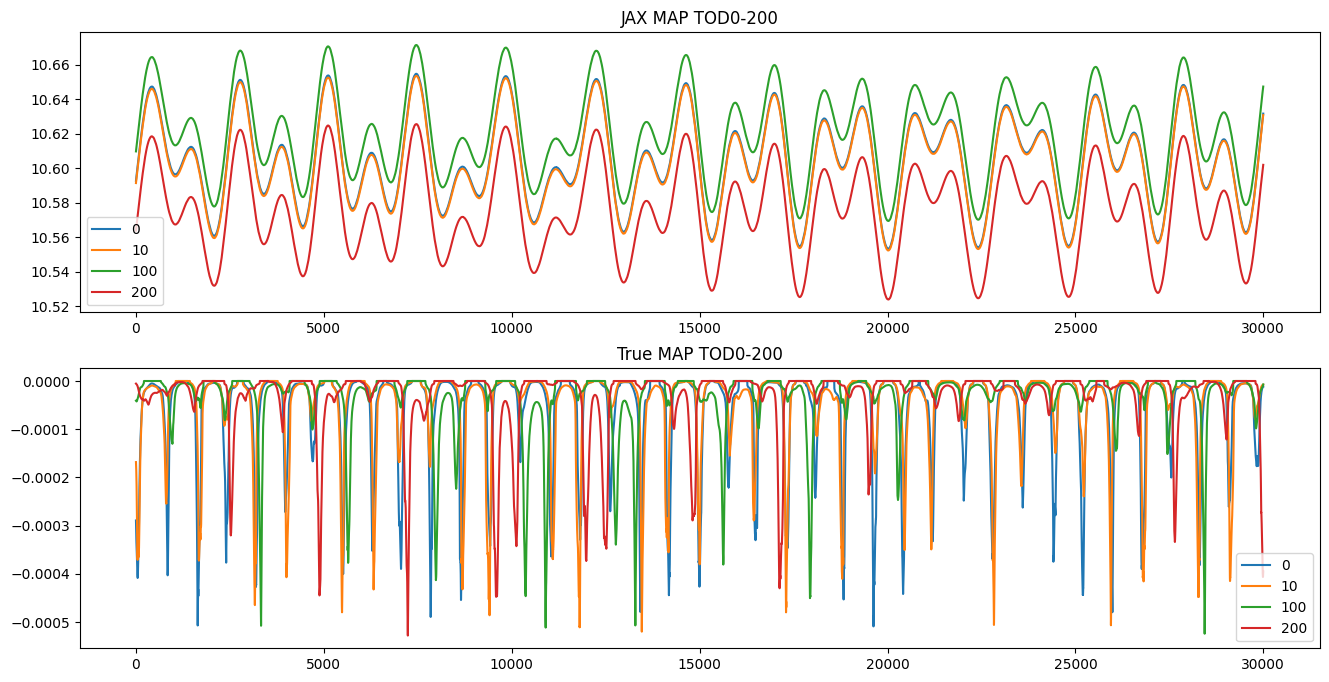

In [12]:
# jax_tods = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
jax_tods = sample_maps(atmosdata_truth[np.newaxis, :, :], dx, dy, sim_truthmap.map.resolution, x_side, y_side)

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods[i], label=i)

    tods_map = np.float64(tod_truthmap.components['map'].compute())
    im1 = axes[1].plot(tods_map[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True MAP TOD0-{i}')
axes[1].legend()

plt.show()

# Next, initialise nifty prior model

Noise stddev: 0.00025190943


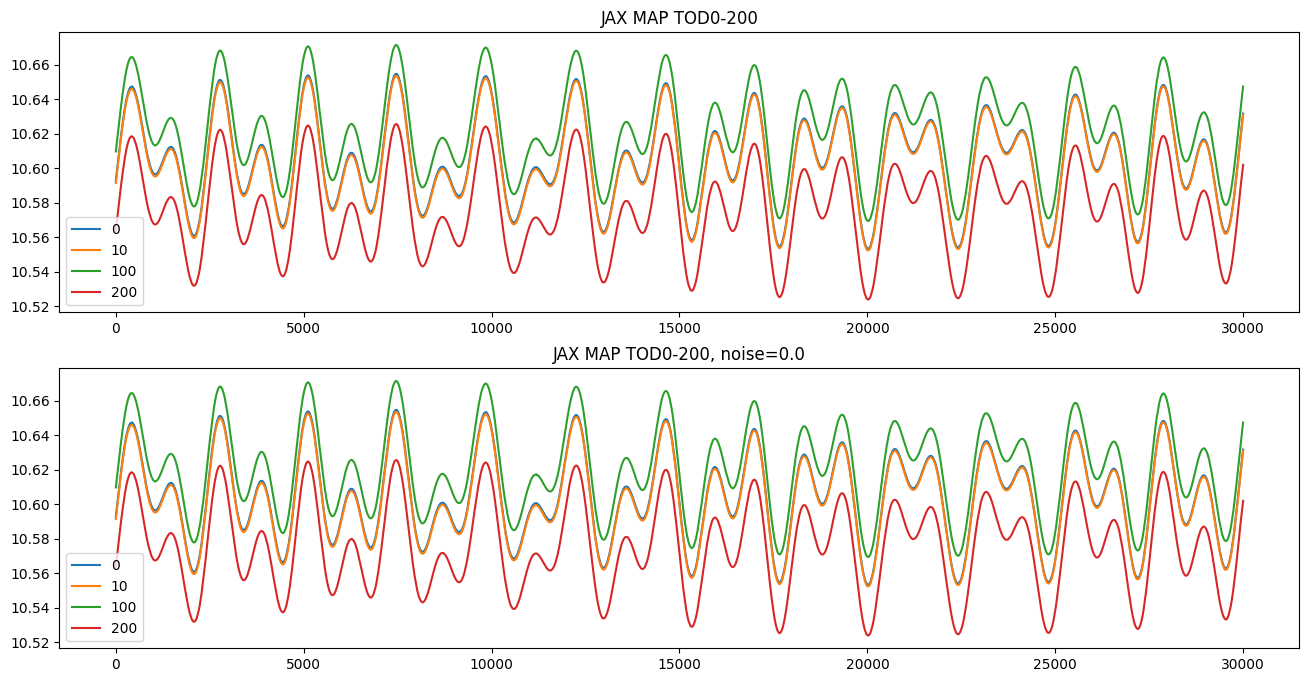

In [13]:
# Pick noise level for rest of run:
noiselevel = 0.0
# noiselevel = 0.1
# noiselevel = 0.5
# noiselevel = 1.0

# jax_tods = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
noised_jax_tod = jax_tods + np.float64(tod_truthmap.components['noise']*noiselevel)

print("Noise stddev:", np.std(tod_truthmap.components['noise'].compute()))

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods[i], label=i)

    im1 = axes[1].plot(noised_jax_tod[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'JAX MAP TOD0-{i}, noise={noiselevel}')
axes[1].legend()

plt.show()

In [14]:
# dims = (1000, 1000)
# dims = (1024, 1024)
# dims = (200, 200)
# dims = (220, 220)
dims = (300, 300)
padding = dims[0] - atmosdata_truth.shape[0]
# Map model

# correlated field zero mode GP offset and stddev
# cf_zm_map = dict(offset_mean=-8.7e-5, offset_std=(5e-6, 5e-6))
# cf_zm_map = dict(offset_mean=1.3e-4, offset_std=(5e-5, 5e-5))
cf_zm_map = dict(offset_mean=atmosdata_truth.mean(), offset_std=(atmosdata_truth.mean()/30., atmosdata_truth.mean()/30.))
# correlated field fluctuations (mostly don't need tuning)
cf_fl_map = dict(
    # fluctuations=(1e-3, 1e-4), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    # loglogavgslope=(-3e0, 5e-1), # power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
    # fluctuations=(1e-2, 2e-3), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    fluctuations=(atmosdata_truth.max() - atmosdata_truth.mean(), (atmosdata_truth.max()-atmosdata_truth.mean())/5.),
    loglogavgslope=(-1e1, 5e0), # power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
    flexibility=None,
    asperity=None,
    # flexibility=(1.5e0, 5e-1), # deviation from simple power-law
    # asperity=(5e-1, 5e-2), # small scale features in power-law
)

# put together in correlated field model
cfm_map = jft.CorrelatedFieldMaker("cfmap")
cfm_map.set_amplitude_total_offset(**cf_zm_map)
cfm_map.add_fluctuations(
    dims, distances=1.0 / dims[0], **cf_fl_map, prefix="ax1", non_parametric_kind="power"
)
gp_map = cfm_map.finalize()

In [15]:
# Define simple signal model with added map sampling
class Signal_TOD(jft.Model):
    def __init__(self, gp_map):
        self.gp_map = gp_map
        super().__init__(init=self.gp_map.init, domain=jft.Vector(gp_map.domain))

    def __call__(self, x):
        # return sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims[0], dims[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
        return sample_maps(self.gp_map(x)[jax.numpy.newaxis, padding//2:-padding//2, padding//2:-padding//2], dx, dy, sim_truthmap.map.resolution, x_side, y_side)
        # return sample_maps(self.gp_map(x)[jax.numpy.newaxis, :, :], dx, dy, sim_truthmap.map.resolution, x_side, y_side)

class Signal_map(jft.Model):
    def __init__(self, gp_map):
        self.gp_map = gp_map
        super().__init__(init=self.gp_map.init, domain=jft.Vector(gp_map.domain))

    def __call__(self, x):
        return self.gp_map(x)
  
signal_response_tod = Signal_TOD(gp_map)
signal_response_map = Signal_map(gp_map)

# Define noise covariance
noise_cov_inv_map = lambda x: 1e-4**-2 * x
if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 1e-8**-2 * x
# if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x
elif noiselevel == 0.1: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 0.5: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 1.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x

# Combine in likelihood
tods_map = np.float64(tod_truthmap.data.compute())
# lh_tod = jft.Gaussian( jax_tods, noise_cov_inv_tod).amend(signal_response_tod)
lh_tod = jft.Gaussian( noised_jax_tod, noise_cov_inv_tod).amend(signal_response_tod)
# lh_map = jft.Gaussian( mapdata_truth[0], noise_cov_inv_map).amend(signal_response_map) # true map

# lh = lh_tod + lh_map
# lh = lh_map
lh = lh_tod

# lh_map_grad = jax.grad(lh_map)
lh_tod_grad = jax.grad(lh_tod)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


In [16]:
key, sub = random.split(key)
# print(lh_map_grad(jft.random_like(sub, lh_map.domain)))
print(lh_tod_grad(jft.random_like(sub, lh_tod.domain)))

Vector(
	{'cfmapax1fluctuations': Array(2.50276941e+19, dtype=float64),
	 'cfmapax1loglogavgslope': Array(-1.94631701e+19, dtype=float64),
	 'cfmapxi': Array([[-4.53122434e+20,  1.77601541e+19,  3.63476674e+17, ...,
	        -2.79485729e+17, -3.40676607e+17,  2.92031081e+19],
	       [-3.36068847e+19,  1.43231723e+19, -2.59406445e+18, ...,
	         2.37855793e+17, -1.08352335e+18,  6.61766581e+18],
	       [ 6.70228893e+18, -4.73212738e+18,  1.37226754e+18, ...,
	        -6.72874773e+16,  6.34451658e+17, -3.07155300e+18],
	       ...,
	       [ 4.64271050e+17, -4.02349900e+17,  1.27921069e+17, ...,
	         9.69873383e+15, -5.13617105e+16, -1.20454103e+17],
	       [-5.52473201e+18,  3.23119489e+18, -6.09462768e+17, ...,
	        -7.64326138e+16, -9.45465615e+16,  2.23522319e+18],
	       [ 7.46107648e+19, -1.81824959e+19,  1.44162283e+18, ...,
	         1.74203262e+17,  8.08699639e+17, -1.66312412e+19]],      dtype=float64),
	 'cfmapzeromode': Array(6.52255021e+19, dtype=float64)}
)

# Draw Prior sample

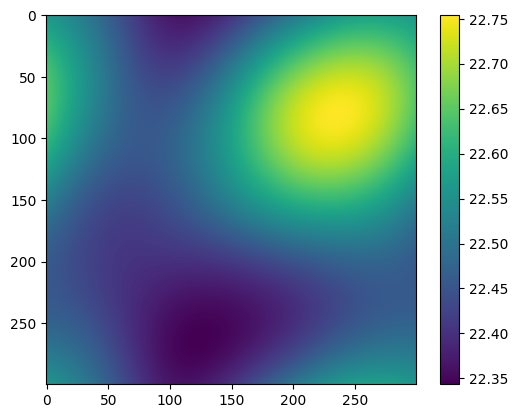

In [17]:
key = random.PRNGKey(123)
key, subkey = jax.random.split(key)
xi = jft.random_like(subkey, gp_map.domain)
res = gp_map(xi)

plt.imshow(res)
plt.colorbar()

In [18]:
todlist_prior = []

for i in range(5):
    key, subkey = jax.random.split(key)
    xi = jft.random_like(subkey, gp_map.domain)
    tod1 = signal_response_tod(xi)
    todlist_prior.append(tod1)
    
    
mean, std = jft.mean_and_std(tuple(todlist_prior))

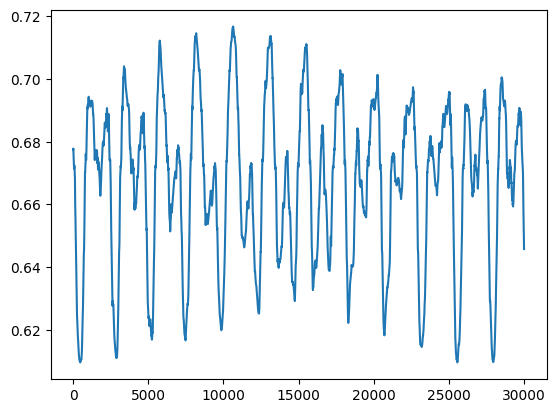

In [19]:
plt.plot(std[0])

# MAP fit

In [20]:
n_it = 1
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4

n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60 # map
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=20 # map
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001
M: →:1.0 ↺:False #∇²:06 |↘|:1.127375e+01 ➽:9.000300e+00
M: Iteration 1 ⛰:+5.773484e+18 Δ⛰:8.516110e+19
M: →:1.0 ↺:False #∇²:12 |↘|:5.935625e+00 ➽:9.000300e+00
M: Iteration 2 ⛰:+9.059308e+17 Δ⛰:4.867553e+18
OPTIMIZE_KL: Iteration 0001 ⛰:+9.0593e+17
OPTIMIZE_KL: #(KL minimization steps) 2
OPTIMIZE_KL: Likelihood residual(s):
'reduced χ²: 2.8e+11±     0.0, avg: +6.3e+04±     0.0, #dof:6510000'

OPTIMIZE_KL: Prior residual(s):
cfmapax1fluctuations    :: 'reduced χ²:     1.3±     0.0, avg:     -1.1±     0.0, #dof:      1'
cfmapax1loglogavgslope  :: 'reduced χ²:    0.36±     0.0, avg:     -0.6±     0.0, #dof:      1'
cfmapxi                 :: 'reduced χ²:     1.0±     0.0, avg: -0.00044±     0.0, #dof:  90000'
cfmapzeromode           :: 'reduced χ²:   0.092±     0.0, avg:     -0.3±     0.0, #dof:      1'




In [21]:
def printfitresults():
    print("Fit Results (res, init, std)")
    print(f"fluctuations: {jft.LogNormalPrior(*cf_fl_map['fluctuations'])(samples.pos['cfmapax1fluctuations'])}, {cf_fl_map['fluctuations'][0]}, {cf_fl_map['fluctuations'][1]}")
    print(f"loglogvarslope: {jft.NormalPrior(*cf_fl_map['loglogavgslope'])(samples.pos['cfmapax1loglogavgslope'])}, {cf_fl_map['loglogavgslope'][0]}, {cf_fl_map['loglogavgslope'][1]}")
    print(f"zeromode: {jft.LogNormalPrior(cf_zm_map['offset_mean'], cf_zm_map['offset_std'][0])(samples.pos['cfmapzeromode'])}, {cf_zm_map['offset_mean']}, {cf_zm_map['offset_std'][0]}")
    
printfitresults()

Fit Results (res, init, std)
fluctuations: 0.13249116538077535, 0.16871608827074525, 0.033743217654149046
loglogvarslope: -13.016742370025723, -10.0, 5.0
zeromode: 20.732712409622074, 20.95525829052564, 0.698508609684188


(200, 200)


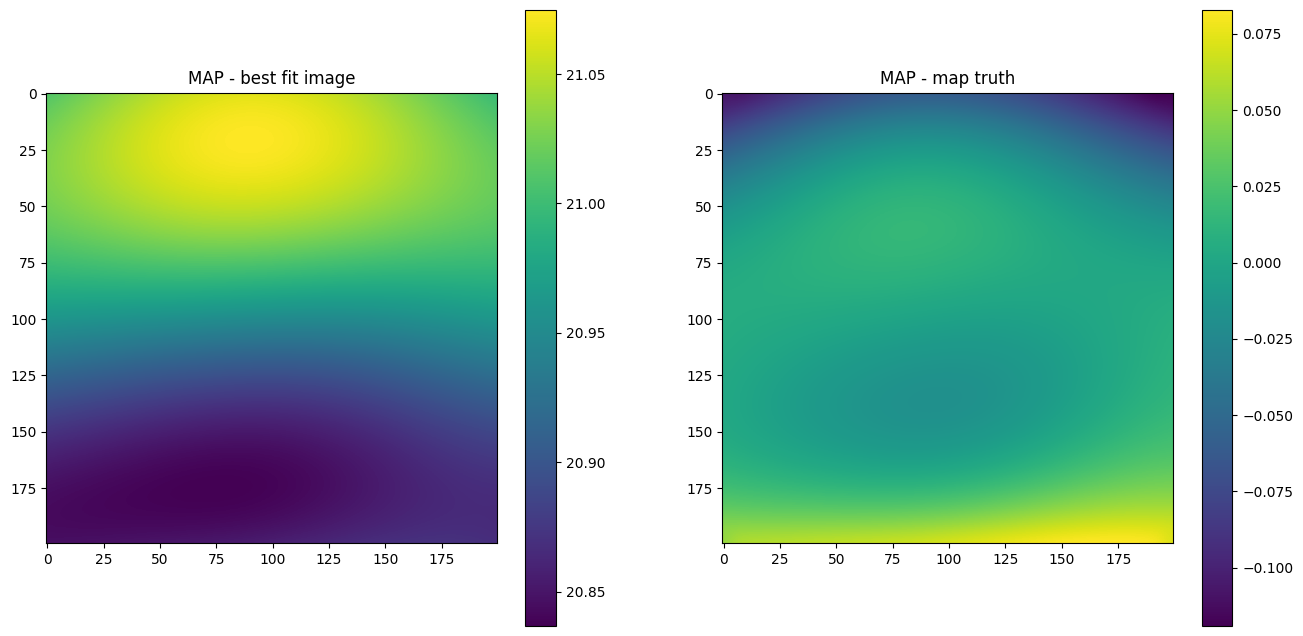

In [22]:
# plot maximum of posterior (mode)
# sig_map = signal_response(samples.pos) # gives time-series
sig_map = gp_map(samples.pos)[padding//2:-padding//2, padding//2:-padding//2] # when splitting up in different field models
# sig_map = gp_map(samples.pos) # when splitting up in different field models
print(sig_map.shape)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(sig_map)
axes[0].title.set_text('MAP - best fit image')
fig.colorbar(im0)

# im1 = axes[1].imshow( sig_map - mapdata_truth[0] )
im1 = axes[1].imshow( sig_map - atmosdata_truth )
axes[1].title.set_text('MAP - map truth')
# im1 = axes[1].imshow( (sig_map - mapdata_truth) )
# axes[1].title.set_text('diff prediction - map truth')
fig.colorbar(im1)

plt.show()

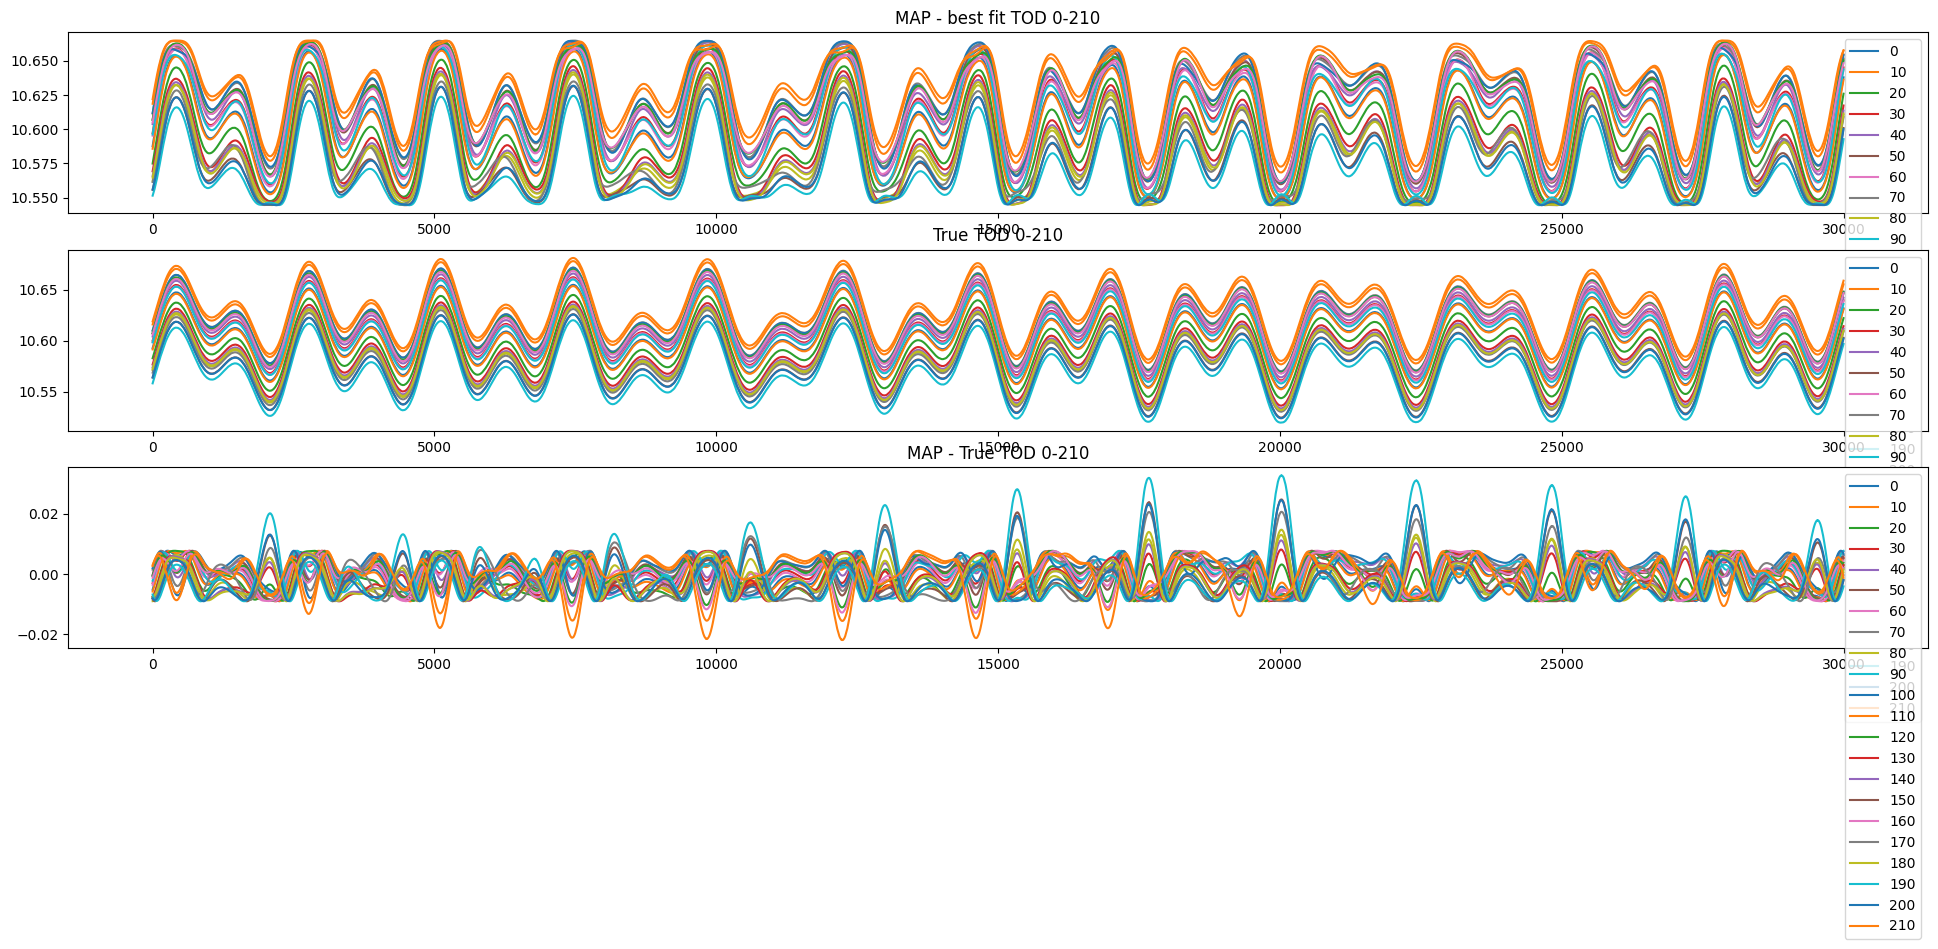

In [23]:
# plot maximum of posterior (mode)
pred_tods = signal_response_tod(samples.pos) # gives time-series

fig, axes = plt.subplots(3, 1, figsize=(8*3, 8))

# for i in [0, 10, 100, 200]:
for i in range(0, len(jax_tods), len(jax_tods)//20):
    im0 = axes[0].plot(pred_tods[i], label=i)
    # im1 = axes[1].plot(tods_map[i], label=i)
    im1 = axes[1].plot(jax_tods[i], label=i)
    im2 = axes[2].plot(pred_tods[i] - jax_tods[i], label=i)
    
axes[0].title.set_text(f'MAP - best fit TOD 0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True TOD 0-{i}')
axes[1].legend()
axes[2].title.set_text(f'MAP - True TOD 0-{i}')
axes[2].legend()

plt.show()

In [24]:
# assert False

## Full nifty fit:

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+3.1651e+21 Δ⛰:inf ➽:9.0003e-07
SL: Iteration 1 ⛰:+5.3548e+19 Δ⛰:3.1116e+21 ➽:9.0003e-07
SL: Iteration 2 ⛰:+1.5838e+19 Δ⛰:3.7710e+19 ➽:9.0003e-07
SL: Iteration 3 ⛰:+6.6466e+18 Δ⛰:9.1911e+18 ➽:9.0003e-07
SL: Iteration 4 ⛰:+3.4280e+18 Δ⛰:3.2186e+18 ➽:9.0003e-07
SL: Iteration 5 ⛰:+2.2947e+18 Δ⛰:1.1333e+18 ➽:9.0003e-07
SL: Iteration 6 ⛰:+1.7552e+18 Δ⛰:5.3956e+17 ➽:9.0003e-07
SL: Iteration 7 ⛰:+9.1131e+17 Δ⛰:8.4388e+17 ➽:9.0003e-07
SL: Iteration 8 ⛰:+7.8285e+17 Δ⛰:1.2846e+17 ➽:9.0003e-07
SL: Iteration 9 ⛰:+3.1760e+17 Δ⛰:4.6525e+17 ➽:9.0003e-07
SL: Iteration 10 ⛰:+1.8046e+17 Δ⛰:1.3715e+17 ➽:9.0003e-07
SL: Iteration 11 ⛰:+1.8045e+17 Δ⛰:1.1769e+13 ➽:9.0003e-07
SL: Iteration 12 ⛰:+7.8512e+16 Δ⛰:1.0193e+17 ➽:9.0003e-07
SL: Iteration 13 ⛰:+5.7275e+16 Δ⛰:2.1237e+16 ➽:9.0003e-07
SL: Iteration 14 ⛰:+5.2010e+16 Δ⛰:5.2644e+15 ➽:9.0003e-07
SL: Iteration 15 ⛰:+5.0583e+16 Δ⛰:1.4270e+15 ➽:9.0003e-07
SL: Iteration 16 ⛰:+4.5776e+16 Δ⛰:4.8077e+15 ➽:9.0003e-07
SL: 

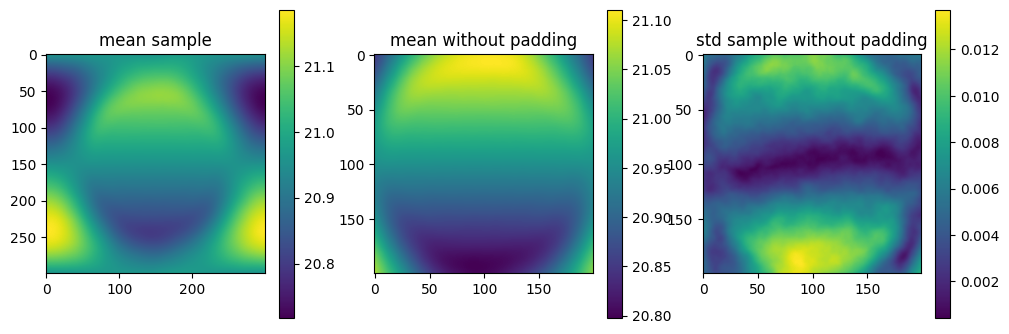

OPTIMIZE_KL: Starting 0002
SL: Iteration 0 ⛰:+8.2700e+17 Δ⛰:inf ➽:9.0003e-07
SL: Iteration 1 ⛰:+3.3501e+17 Δ⛰:4.9199e+17 ➽:9.0003e-07
SL: Iteration 2 ⛰:+1.5724e+17 Δ⛰:1.7776e+17 ➽:9.0003e-07
SL: Iteration 3 ⛰:+9.4758e+16 Δ⛰:6.2486e+16 ➽:9.0003e-07
SL: Iteration 4 ⛰:+7.1655e+16 Δ⛰:2.3103e+16 ➽:9.0003e-07
SL: Iteration 5 ⛰:+4.3213e+16 Δ⛰:2.8442e+16 ➽:9.0003e-07
SL: Iteration 6 ⛰:+2.8249e+16 Δ⛰:1.4964e+16 ➽:9.0003e-07
SL: Iteration 7 ⛰:+1.9662e+16 Δ⛰:8.5871e+15 ➽:9.0003e-07
SL: Iteration 8 ⛰:+1.5191e+16 Δ⛰:4.4702e+15 ➽:9.0003e-07
SL: Iteration 9 ⛰:+1.4692e+16 Δ⛰:4.9939e+14 ➽:9.0003e-07
SL: Iteration 10 ⛰:+9.2217e+15 Δ⛰:5.4703e+15 ➽:9.0003e-07
SL: Iteration 11 ⛰:+6.2649e+15 Δ⛰:2.9568e+15 ➽:9.0003e-07
SL: Iteration 12 ⛰:+5.1427e+15 Δ⛰:1.1222e+15 ➽:9.0003e-07
SL: Iteration 13 ⛰:+5.0205e+15 Δ⛰:1.2226e+14 ➽:9.0003e-07
SL: Iteration 14 ⛰:+4.9445e+15 Δ⛰:7.5918e+13 ➽:9.0003e-07
SL: Iteration 15 ⛰:+4.4509e+15 Δ⛰:4.9366e+14 ➽:9.0003e-07
SL: Iteration 16 ⛰:+4.1033e+15 Δ⛰:3.4763e+14 ➽:9.0003e-07
SL: 

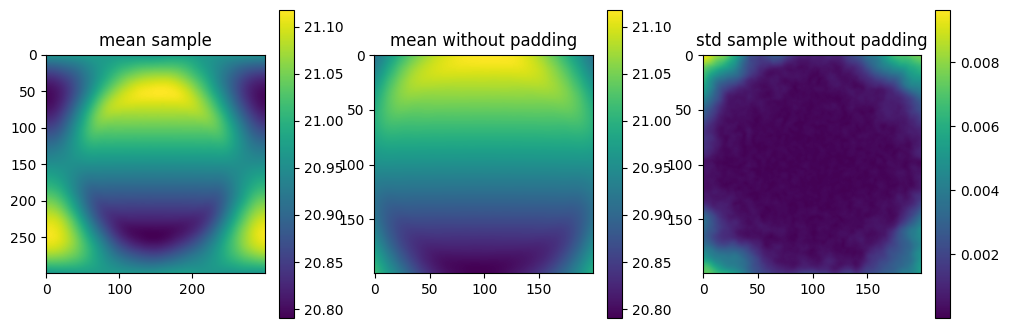

OPTIMIZE_KL: Starting 0003
SL: Iteration 0 ⛰:+1.3214e+18 Δ⛰:inf ➽:9.0003e-07
SL: Iteration 1 ⛰:+6.5861e+17 Δ⛰:6.6283e+17 ➽:9.0003e-07
SL: Iteration 2 ⛰:+1.4332e+17 Δ⛰:5.1529e+17 ➽:9.0003e-07
SL: Iteration 3 ⛰:+2.7136e+16 Δ⛰:1.1619e+17 ➽:9.0003e-07
SL: Iteration 4 ⛰:+2.5819e+16 Δ⛰:1.3164e+15 ➽:9.0003e-07
SL: Iteration 5 ⛰:+1.6935e+16 Δ⛰:8.8843e+15 ➽:9.0003e-07
SL: Iteration 6 ⛰:+1.2957e+16 Δ⛰:3.9779e+15 ➽:9.0003e-07
SL: Iteration 7 ⛰:+7.9757e+15 Δ⛰:4.9813e+15 ➽:9.0003e-07
SL: Iteration 8 ⛰:+5.4797e+15 Δ⛰:2.4960e+15 ➽:9.0003e-07
SL: Iteration 9 ⛰:+5.3563e+15 Δ⛰:1.2340e+14 ➽:9.0003e-07
SL: Iteration 10 ⛰:+4.5287e+15 Δ⛰:8.2768e+14 ➽:9.0003e-07
SL: Iteration 11 ⛰:+3.4595e+15 Δ⛰:1.0691e+15 ➽:9.0003e-07
SL: Iteration 12 ⛰:+2.9240e+15 Δ⛰:5.3555e+14 ➽:9.0003e-07
SL: Iteration 13 ⛰:+2.9189e+15 Δ⛰:5.1151e+12 ➽:9.0003e-07
SL: Iteration 14 ⛰:+2.5971e+15 Δ⛰:3.2180e+14 ➽:9.0003e-07
SL: Iteration 15 ⛰:+2.2673e+15 Δ⛰:3.2979e+14 ➽:9.0003e-07
SL: Iteration 16 ⛰:+2.2492e+15 Δ⛰:1.8014e+13 ➽:9.0003e-07
SL: 

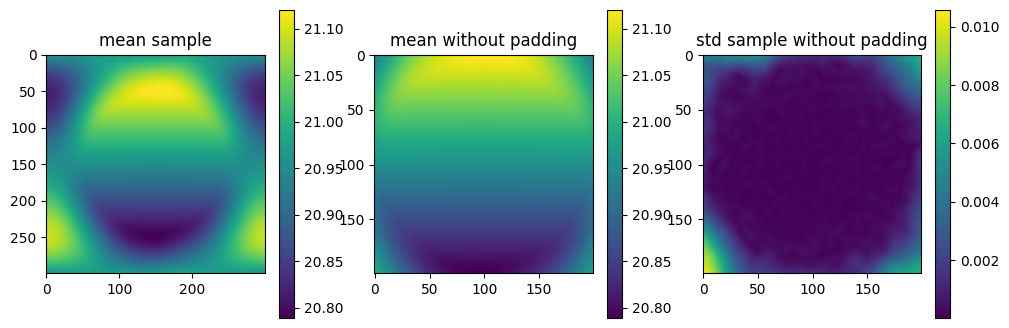

OPTIMIZE_KL: Starting 0004
SL: Iteration 0 ⛰:+3.7398e+18 Δ⛰:inf ➽:9.0003e-07
SL: Iteration 1 ⛰:+1.4266e+18 Δ⛰:2.3132e+18 ➽:9.0003e-07
SL: Iteration 2 ⛰:+2.1446e+17 Δ⛰:1.2122e+18 ➽:9.0003e-07
SL: Iteration 3 ⛰:+1.2562e+17 Δ⛰:8.8840e+16 ➽:9.0003e-07
SL: Iteration 4 ⛰:+9.1928e+16 Δ⛰:3.3690e+16 ➽:9.0003e-07
SL: Iteration 5 ⛰:+5.2473e+16 Δ⛰:3.9456e+16 ➽:9.0003e-07
SL: Iteration 6 ⛰:+2.6793e+16 Δ⛰:2.5679e+16 ➽:9.0003e-07
SL: Iteration 7 ⛰:+1.7346e+16 Δ⛰:9.4470e+15 ➽:9.0003e-07
SL: Iteration 8 ⛰:+1.1265e+16 Δ⛰:6.0818e+15 ➽:9.0003e-07
SL: Iteration 9 ⛰:+1.0856e+16 Δ⛰:4.0810e+14 ➽:9.0003e-07
SL: Iteration 10 ⛰:+5.1131e+15 Δ⛰:5.7434e+15 ➽:9.0003e-07
SL: Iteration 11 ⛰:+3.1415e+15 Δ⛰:1.9716e+15 ➽:9.0003e-07
SL: Iteration 12 ⛰:+3.0036e+15 Δ⛰:1.3788e+14 ➽:9.0003e-07
SL: Iteration 13 ⛰:+2.7231e+15 Δ⛰:2.8052e+14 ➽:9.0003e-07
SL: Iteration 14 ⛰:+2.6889e+15 Δ⛰:3.4200e+13 ➽:9.0003e-07
SL: Iteration 15 ⛰:+2.0546e+15 Δ⛰:6.3433e+14 ➽:9.0003e-07
SL: Iteration 16 ⛰:+2.0537e+15 Δ⛰:8.4133e+11 ➽:9.0003e-07
SL: 

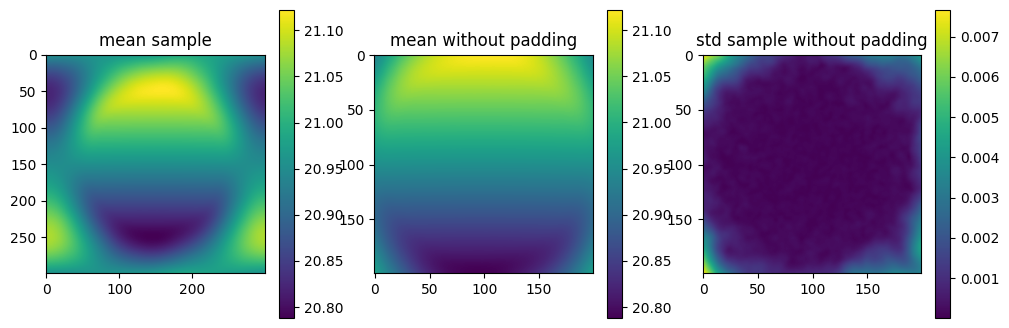

OPTIMIZE_KL: Starting 0005
SL: Iteration 0 ⛰:+4.5877e+19 Δ⛰:inf ➽:9.0003e-07
SL: Iteration 1 ⛰:+2.1564e+18 Δ⛰:4.3720e+19 ➽:9.0003e-07
SL: Iteration 2 ⛰:+2.8914e+17 Δ⛰:1.8672e+18 ➽:9.0003e-07
SL: Iteration 3 ⛰:+1.4951e+17 Δ⛰:1.3963e+17 ➽:9.0003e-07
SL: Iteration 4 ⛰:+1.0219e+17 Δ⛰:4.7323e+16 ➽:9.0003e-07
SL: Iteration 5 ⛰:+4.1595e+16 Δ⛰:6.0591e+16 ➽:9.0003e-07
SL: Iteration 6 ⛰:+2.3123e+16 Δ⛰:1.8472e+16 ➽:9.0003e-07
SL: Iteration 7 ⛰:+1.4612e+16 Δ⛰:8.5113e+15 ➽:9.0003e-07
SL: Iteration 8 ⛰:+8.0581e+15 Δ⛰:6.5538e+15 ➽:9.0003e-07
SL: Iteration 9 ⛰:+7.9618e+15 Δ⛰:9.6311e+13 ➽:9.0003e-07
SL: Iteration 10 ⛰:+4.0917e+15 Δ⛰:3.8701e+15 ➽:9.0003e-07
SL: Iteration 11 ⛰:+3.5432e+15 Δ⛰:5.4846e+14 ➽:9.0003e-07
SL: Iteration 12 ⛰:+3.5359e+15 Δ⛰:7.3105e+12 ➽:9.0003e-07
SL: Iteration 13 ⛰:+2.6612e+15 Δ⛰:8.7466e+14 ➽:9.0003e-07
SL: Iteration 14 ⛰:+2.4158e+15 Δ⛰:2.4540e+14 ➽:9.0003e-07
SL: Iteration 15 ⛰:+2.3364e+15 Δ⛰:7.9462e+13 ➽:9.0003e-07
SL: Iteration 16 ⛰:+2.3345e+15 Δ⛰:1.8097e+12 ➽:9.0003e-07
SL: 

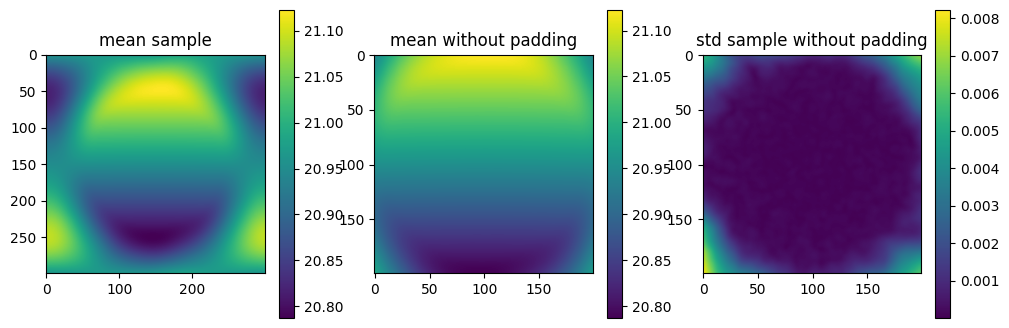

OPTIMIZE_KL: Starting 0006
SL: Iteration 0 ⛰:+4.7342e+18 Δ⛰:inf ➽:9.0003e-07
SL: Iteration 1 ⛰:+2.4747e+18 Δ⛰:2.2594e+18 ➽:9.0003e-07
SL: Iteration 2 ⛰:+5.5265e+17 Δ⛰:1.9221e+18 ➽:9.0003e-07
SL: Iteration 3 ⛰:+2.2829e+17 Δ⛰:3.2437e+17 ➽:9.0003e-07
SL: Iteration 4 ⛰:+7.2648e+16 Δ⛰:1.5564e+17 ➽:9.0003e-07
SL: Iteration 5 ⛰:+1.9595e+16 Δ⛰:5.3054e+16 ➽:9.0003e-07
SL: Iteration 6 ⛰:+1.2499e+16 Δ⛰:7.0956e+15 ➽:9.0003e-07
SL: Iteration 7 ⛰:+8.0566e+15 Δ⛰:4.4424e+15 ➽:9.0003e-07
SL: Iteration 8 ⛰:+5.6166e+15 Δ⛰:2.4401e+15 ➽:9.0003e-07
SL: Iteration 9 ⛰:+5.6082e+15 Δ⛰:8.3635e+12 ➽:9.0003e-07
SL: Iteration 10 ⛰:+3.6383e+15 Δ⛰:1.9699e+15 ➽:9.0003e-07
SL: Iteration 11 ⛰:+3.0612e+15 Δ⛰:5.7710e+14 ➽:9.0003e-07
SL: Iteration 12 ⛰:+3.0577e+15 Δ⛰:3.5009e+12 ➽:9.0003e-07
SL: Iteration 13 ⛰:+2.2694e+15 Δ⛰:7.8830e+14 ➽:9.0003e-07
SL: Iteration 14 ⛰:+2.0190e+15 Δ⛰:2.5038e+14 ➽:9.0003e-07
SL: Iteration 15 ⛰:+1.9797e+15 Δ⛰:3.9338e+13 ➽:9.0003e-07
SL: Iteration 16 ⛰:+1.6296e+15 Δ⛰:3.5003e+14 ➽:9.0003e-07
SL: 

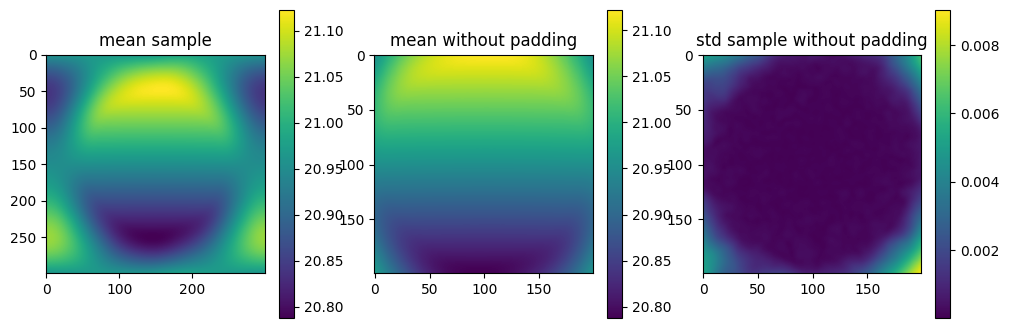

OPTIMIZE_KL: Starting 0007
SL: Iteration 0 ⛰:+1.0790e+19 Δ⛰:inf ➽:9.0003e-07
SL: Iteration 1 ⛰:+3.0739e+18 Δ⛰:7.7162e+18 ➽:9.0003e-07
SL: Iteration 2 ⛰:+2.3990e+17 Δ⛰:2.8340e+18 ➽:9.0003e-07
SL: Iteration 3 ⛰:+9.9335e+16 Δ⛰:1.4057e+17 ➽:9.0003e-07
SL: Iteration 4 ⛰:+6.4925e+16 Δ⛰:3.4411e+16 ➽:9.0003e-07
SL: Iteration 5 ⛰:+3.3923e+16 Δ⛰:3.1002e+16 ➽:9.0003e-07
SL: Iteration 6 ⛰:+1.5651e+16 Δ⛰:1.8272e+16 ➽:9.0003e-07
SL: Iteration 7 ⛰:+9.2685e+15 Δ⛰:6.3822e+15 ➽:9.0003e-07
SL: Iteration 8 ⛰:+6.6899e+15 Δ⛰:2.5785e+15 ➽:9.0003e-07
SL: Iteration 9 ⛰:+6.6852e+15 Δ⛰:4.7349e+12 ➽:9.0003e-07
SL: Iteration 10 ⛰:+3.0481e+15 Δ⛰:3.6371e+15 ➽:9.0003e-07
SL: Iteration 11 ⛰:+1.5866e+15 Δ⛰:1.4615e+15 ➽:9.0003e-07
SL: Iteration 12 ⛰:+1.5789e+15 Δ⛰:7.7124e+12 ➽:9.0003e-07
SL: Iteration 13 ⛰:+1.1368e+15 Δ⛰:4.4202e+14 ➽:9.0003e-07
SL: Iteration 14 ⛰:+1.1244e+15 Δ⛰:1.2442e+13 ➽:9.0003e-07
SL: Iteration 15 ⛰:+9.8316e+14 Δ⛰:1.4124e+14 ➽:9.0003e-07
SL: Iteration 16 ⛰:+9.8280e+14 Δ⛰:3.5643e+11 ➽:9.0003e-07
SL: 

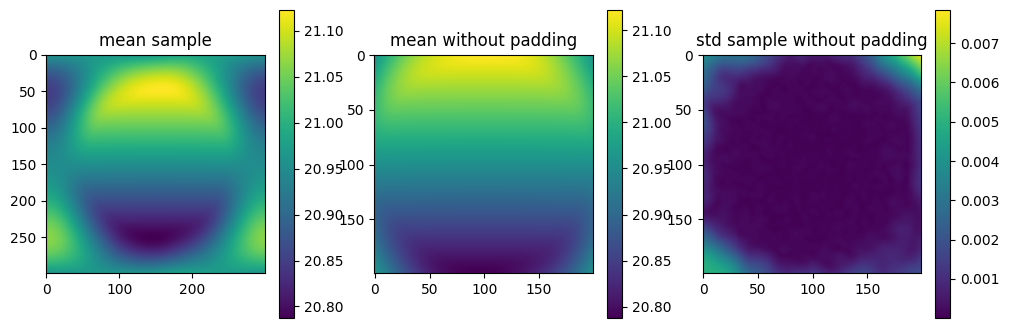

OPTIMIZE_KL: Starting 0008
SL: Iteration 0 ⛰:+8.6571e+18 Δ⛰:inf ➽:9.0003e-07
SL: Iteration 1 ⛰:+3.7778e+18 Δ⛰:4.8793e+18 ➽:9.0003e-07
SL: Iteration 2 ⛰:+3.6103e+17 Δ⛰:3.4168e+18 ➽:9.0003e-07
SL: Iteration 3 ⛰:+7.5541e+16 Δ⛰:2.8549e+17 ➽:9.0003e-07
SL: Iteration 4 ⛰:+7.0182e+16 Δ⛰:5.3586e+15 ➽:9.0003e-07
SL: Iteration 5 ⛰:+4.1621e+16 Δ⛰:2.8561e+16 ➽:9.0003e-07
SL: Iteration 6 ⛰:+1.4117e+16 Δ⛰:2.7504e+16 ➽:9.0003e-07
SL: Iteration 7 ⛰:+7.5383e+15 Δ⛰:6.5786e+15 ➽:9.0003e-07
SL: Iteration 8 ⛰:+5.7017e+15 Δ⛰:1.8366e+15 ➽:9.0003e-07
SL: Iteration 9 ⛰:+5.5886e+15 Δ⛰:1.1302e+14 ➽:9.0003e-07
SL: Iteration 10 ⛰:+3.9171e+15 Δ⛰:1.6716e+15 ➽:9.0003e-07
SL: Iteration 11 ⛰:+2.6108e+15 Δ⛰:1.3063e+15 ➽:9.0003e-07
SL: Iteration 12 ⛰:+1.6649e+15 Δ⛰:9.4589e+14 ➽:9.0003e-07
SL: Iteration 13 ⛰:+1.5983e+15 Δ⛰:6.6558e+13 ➽:9.0003e-07
SL: Iteration 14 ⛰:+1.5915e+15 Δ⛰:6.8489e+12 ➽:9.0003e-07
SL: Iteration 15 ⛰:+1.5169e+15 Δ⛰:7.4612e+13 ➽:9.0003e-07
SL: Iteration 16 ⛰:+1.4193e+15 Δ⛰:9.7574e+13 ➽:9.0003e-07
SL: 

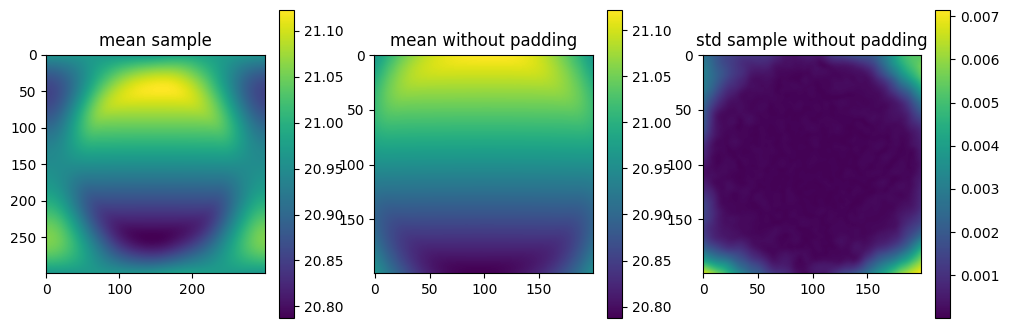

OPTIMIZE_KL: Starting 0009
SL: Iteration 0 ⛰:+8.9516e+18 Δ⛰:inf ➽:9.0003e-07
SL: Iteration 1 ⛰:+2.0626e+18 Δ⛰:6.8890e+18 ➽:9.0003e-07
SL: Iteration 2 ⛰:+5.4400e+17 Δ⛰:1.5186e+18 ➽:9.0003e-07
SL: Iteration 3 ⛰:+1.1381e+17 Δ⛰:4.3018e+17 ➽:9.0003e-07
SL: Iteration 4 ⛰:+7.6996e+16 Δ⛰:3.6816e+16 ➽:9.0003e-07
SL: Iteration 5 ⛰:+3.2158e+16 Δ⛰:4.4839e+16 ➽:9.0003e-07
SL: Iteration 6 ⛰:+2.1604e+16 Δ⛰:1.0554e+16 ➽:9.0003e-07
SL: Iteration 7 ⛰:+1.0275e+16 Δ⛰:1.1328e+16 ➽:9.0003e-07
SL: Iteration 8 ⛰:+3.9419e+15 Δ⛰:6.3335e+15 ➽:9.0003e-07
SL: Iteration 9 ⛰:+3.8192e+15 Δ⛰:1.2270e+14 ➽:9.0003e-07
SL: Iteration 10 ⛰:+2.8051e+15 Δ⛰:1.0141e+15 ➽:9.0003e-07
SL: Iteration 11 ⛰:+1.6865e+15 Δ⛰:1.1186e+15 ➽:9.0003e-07
SL: Iteration 12 ⛰:+1.6805e+15 Δ⛰:6.0918e+12 ➽:9.0003e-07
SL: Iteration 13 ⛰:+1.2600e+15 Δ⛰:4.2048e+14 ➽:9.0003e-07
SL: Iteration 14 ⛰:+1.2472e+15 Δ⛰:1.2812e+13 ➽:9.0003e-07
SL: Iteration 15 ⛰:+1.1274e+15 Δ⛰:1.1979e+14 ➽:9.0003e-07
SL: Iteration 16 ⛰:+9.7936e+14 Δ⛰:1.4802e+14 ➽:9.0003e-07
SL: 

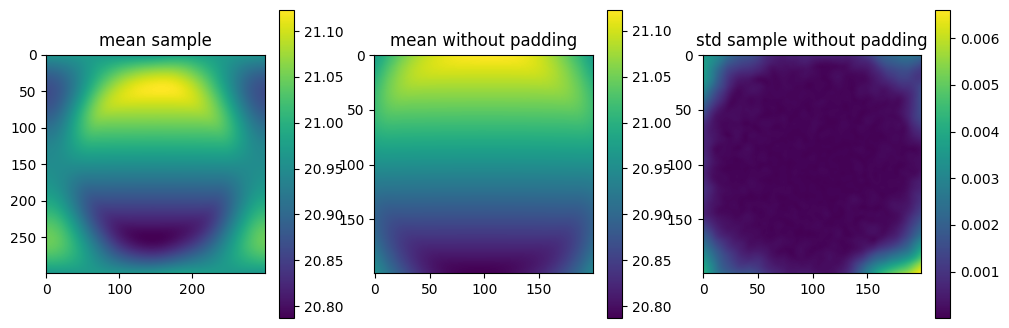

OPTIMIZE_KL: Starting 0010
SL: Iteration 0 ⛰:+8.0640e+18 Δ⛰:inf ➽:9.0003e-07
SL: Iteration 1 ⛰:+8.4005e+17 Δ⛰:7.2240e+18 ➽:9.0003e-07
SL: Iteration 2 ⛰:+2.5236e+17 Δ⛰:5.8770e+17 ➽:9.0003e-07
SL: Iteration 3 ⛰:+6.3500e+16 Δ⛰:1.8886e+17 ➽:9.0003e-07
SL: Iteration 4 ⛰:+4.8839e+16 Δ⛰:1.4661e+16 ➽:9.0003e-07
SL: Iteration 5 ⛰:+2.1129e+16 Δ⛰:2.7710e+16 ➽:9.0003e-07
SL: Iteration 6 ⛰:+1.2476e+16 Δ⛰:8.6527e+15 ➽:9.0003e-07
SL: Iteration 7 ⛰:+6.6395e+15 Δ⛰:5.8369e+15 ➽:9.0003e-07
SL: Iteration 8 ⛰:+5.0445e+15 Δ⛰:1.5950e+15 ➽:9.0003e-07
SL: Iteration 9 ⛰:+4.0813e+15 Δ⛰:9.6318e+14 ➽:9.0003e-07
SL: Iteration 10 ⛰:+2.7082e+15 Δ⛰:1.3731e+15 ➽:9.0003e-07
SL: Iteration 11 ⛰:+1.7352e+15 Δ⛰:9.7294e+14 ➽:9.0003e-07
SL: Iteration 12 ⛰:+1.7338e+15 Δ⛰:1.4214e+12 ➽:9.0003e-07
SL: Iteration 13 ⛰:+1.1428e+15 Δ⛰:5.9100e+14 ➽:9.0003e-07
SL: Iteration 14 ⛰:+1.1297e+15 Δ⛰:1.3160e+13 ➽:9.0003e-07
SL: Iteration 15 ⛰:+1.1259e+15 Δ⛰:3.7592e+12 ➽:9.0003e-07
SL: Iteration 16 ⛰:+9.4358e+14 Δ⛰:1.8232e+14 ➽:9.0003e-07
SL: 

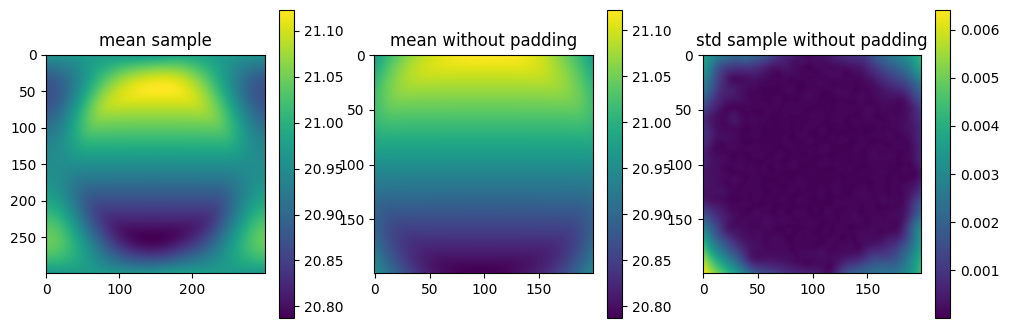

OPTIMIZE_KL: Starting 0011
SL: Iteration 0 ⛰:+1.1108e+19 Δ⛰:inf ➽:9.0003e-07
SL: Iteration 1 ⛰:+9.6099e+17 Δ⛰:1.0147e+19 ➽:9.0003e-07
SL: Iteration 2 ⛰:+1.6095e+17 Δ⛰:8.0004e+17 ➽:9.0003e-07
SL: Iteration 3 ⛰:+6.3695e+16 Δ⛰:9.7252e+16 ➽:9.0003e-07
SL: Iteration 4 ⛰:+4.6808e+16 Δ⛰:1.6887e+16 ➽:9.0003e-07
SL: Iteration 5 ⛰:+3.3616e+16 Δ⛰:1.3192e+16 ➽:9.0003e-07
SL: Iteration 6 ⛰:+1.8349e+16 Δ⛰:1.5268e+16 ➽:9.0003e-07
SL: Iteration 7 ⛰:+9.6649e+15 Δ⛰:8.6837e+15 ➽:9.0003e-07
SL: Iteration 8 ⛰:+7.6913e+15 Δ⛰:1.9736e+15 ➽:9.0003e-07
SL: Iteration 9 ⛰:+6.7509e+15 Δ⛰:9.4043e+14 ➽:9.0003e-07
SL: Iteration 10 ⛰:+2.6546e+15 Δ⛰:4.0963e+15 ➽:9.0003e-07
SL: Iteration 11 ⛰:+1.9837e+15 Δ⛰:6.7084e+14 ➽:9.0003e-07
SL: Iteration 12 ⛰:+1.9353e+15 Δ⛰:4.8472e+13 ➽:9.0003e-07
SL: Iteration 13 ⛰:+1.4631e+15 Δ⛰:4.7215e+14 ➽:9.0003e-07
SL: Iteration 14 ⛰:+1.4532e+15 Δ⛰:9.9328e+12 ➽:9.0003e-07
SL: Iteration 15 ⛰:+1.4412e+15 Δ⛰:1.1986e+13 ➽:9.0003e-07
SL: Iteration 16 ⛰:+1.1439e+15 Δ⛰:2.9732e+14 ➽:9.0003e-07
SL: 

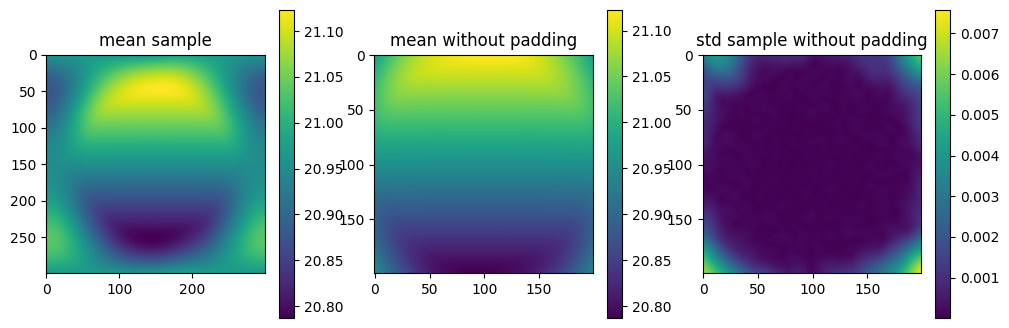

OPTIMIZE_KL: Starting 0012
SL: Iteration 0 ⛰:+1.2345e+19 Δ⛰:inf ➽:9.0003e-07
SL: Iteration 1 ⛰:+1.2402e+18 Δ⛰:1.1105e+19 ➽:9.0003e-07
SL: Iteration 2 ⛰:+2.7748e+17 Δ⛰:9.6273e+17 ➽:9.0003e-07
SL: Iteration 3 ⛰:+1.5283e+17 Δ⛰:1.2465e+17 ➽:9.0003e-07
SL: Iteration 4 ⛰:+4.2594e+16 Δ⛰:1.1024e+17 ➽:9.0003e-07
SL: Iteration 5 ⛰:+1.9391e+16 Δ⛰:2.3202e+16 ➽:9.0003e-07
SL: Iteration 6 ⛰:+1.1404e+16 Δ⛰:7.9870e+15 ➽:9.0003e-07
SL: Iteration 7 ⛰:+8.2120e+15 Δ⛰:3.1924e+15 ➽:9.0003e-07
SL: Iteration 8 ⛰:+6.0245e+15 Δ⛰:2.1876e+15 ➽:9.0003e-07
SL: Iteration 9 ⛰:+5.4684e+15 Δ⛰:5.5610e+14 ➽:9.0003e-07
SL: Iteration 10 ⛰:+1.6573e+15 Δ⛰:3.8111e+15 ➽:9.0003e-07
SL: Iteration 11 ⛰:+1.3708e+15 Δ⛰:2.8645e+14 ➽:9.0003e-07
SL: Iteration 12 ⛰:+1.3607e+15 Δ⛰:1.0091e+13 ➽:9.0003e-07
SL: Iteration 13 ⛰:+1.0958e+15 Δ⛰:2.6497e+14 ➽:9.0003e-07
SL: Iteration 14 ⛰:+1.0854e+15 Δ⛰:1.0328e+13 ➽:9.0003e-07
SL: Iteration 15 ⛰:+1.0276e+15 Δ⛰:5.7794e+13 ➽:9.0003e-07
SL: Iteration 16 ⛰:+8.2933e+14 Δ⛰:1.9831e+14 ➽:9.0003e-07
SL: 

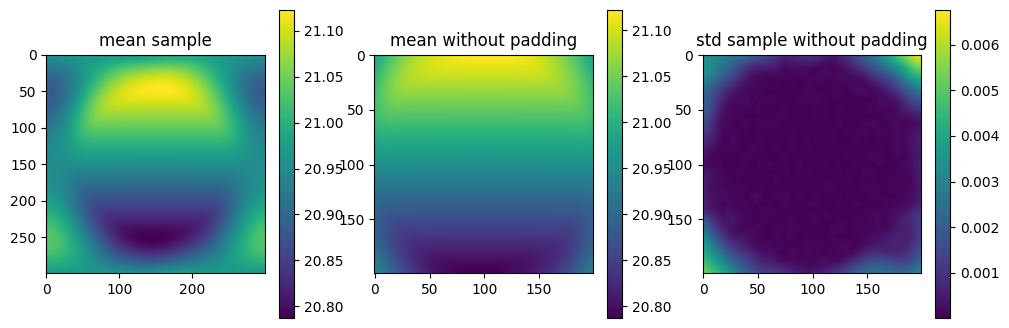

OPTIMIZE_KL: Starting 0013
SL: Iteration 0 ⛰:+3.8362e+18 Δ⛰:inf ➽:9.0003e-07
SL: Iteration 1 ⛰:+9.0517e+17 Δ⛰:2.9310e+18 ➽:9.0003e-07
SL: Iteration 2 ⛰:+4.3182e+17 Δ⛰:4.7335e+17 ➽:9.0003e-07
SL: Iteration 3 ⛰:+2.5731e+17 Δ⛰:1.7451e+17 ➽:9.0003e-07
SL: Iteration 4 ⛰:+4.7294e+16 Δ⛰:2.1002e+17 ➽:9.0003e-07
SL: Iteration 5 ⛰:+2.5205e+16 Δ⛰:2.2089e+16 ➽:9.0003e-07
SL: Iteration 6 ⛰:+8.5964e+15 Δ⛰:1.6609e+16 ➽:9.0003e-07
SL: Iteration 7 ⛰:+4.0806e+15 Δ⛰:4.5158e+15 ➽:9.0003e-07
SL: Iteration 8 ⛰:+3.3891e+15 Δ⛰:6.9151e+14 ➽:9.0003e-07
SL: Iteration 9 ⛰:+3.1779e+15 Δ⛰:2.1121e+14 ➽:9.0003e-07
SL: Iteration 10 ⛰:+1.3686e+15 Δ⛰:1.8093e+15 ➽:9.0003e-07
SL: Iteration 11 ⛰:+1.1757e+15 Δ⛰:1.9288e+14 ➽:9.0003e-07
SL: Iteration 12 ⛰:+1.1744e+15 Δ⛰:1.3347e+12 ➽:9.0003e-07
SL: Iteration 13 ⛰:+9.4002e+14 Δ⛰:2.3434e+14 ➽:9.0003e-07
SL: Iteration 14 ⛰:+9.3283e+14 Δ⛰:7.1854e+12 ➽:9.0003e-07
SL: Iteration 15 ⛰:+9.3009e+14 Δ⛰:2.7419e+12 ➽:9.0003e-07
SL: Iteration 16 ⛰:+7.5400e+14 Δ⛰:1.7609e+14 ➽:9.0003e-07
SL: 

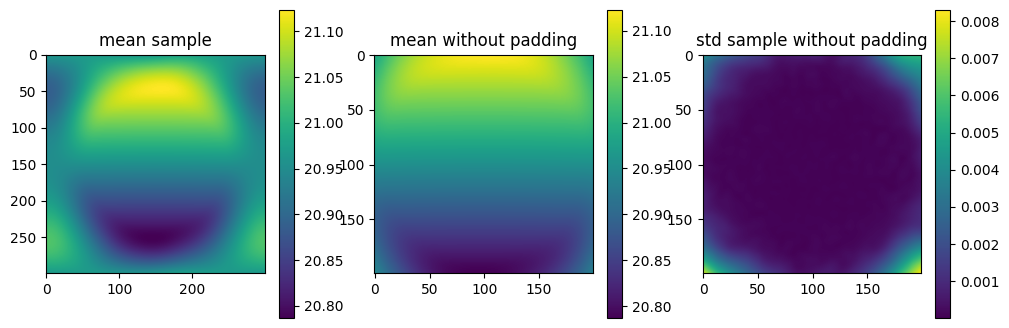

OPTIMIZE_KL: Starting 0014
SL: Iteration 0 ⛰:+1.9460e+19 Δ⛰:inf ➽:9.0003e-07
SL: Iteration 1 ⛰:+4.9370e+18 Δ⛰:1.4523e+19 ➽:9.0003e-07
SL: Iteration 2 ⛰:+9.6013e+17 Δ⛰:3.9768e+18 ➽:9.0003e-07
SL: Iteration 3 ⛰:+4.4542e+16 Δ⛰:9.1559e+17 ➽:9.0003e-07
SL: Iteration 4 ⛰:+1.9506e+16 Δ⛰:2.5036e+16 ➽:9.0003e-07
SL: Iteration 5 ⛰:+9.9108e+15 Δ⛰:9.5954e+15 ➽:9.0003e-07
SL: Iteration 6 ⛰:+5.4955e+15 Δ⛰:4.4153e+15 ➽:9.0003e-07
SL: Iteration 7 ⛰:+4.0903e+15 Δ⛰:1.4052e+15 ➽:9.0003e-07
SL: Iteration 8 ⛰:+3.3038e+15 Δ⛰:7.8656e+14 ➽:9.0003e-07
SL: Iteration 9 ⛰:+2.8957e+15 Δ⛰:4.0809e+14 ➽:9.0003e-07
SL: Iteration 10 ⛰:+1.5950e+15 Δ⛰:1.3007e+15 ➽:9.0003e-07
SL: Iteration 11 ⛰:+1.3035e+15 Δ⛰:2.9144e+14 ➽:9.0003e-07
SL: Iteration 12 ⛰:+1.2973e+15 Δ⛰:6.2238e+12 ➽:9.0003e-07
SL: Iteration 13 ⛰:+8.8440e+14 Δ⛰:4.1292e+14 ➽:9.0003e-07
SL: Iteration 14 ⛰:+8.7576e+14 Δ⛰:8.6426e+12 ➽:9.0003e-07
SL: Iteration 15 ⛰:+8.7360e+14 Δ⛰:2.1614e+12 ➽:9.0003e-07
SL: Iteration 16 ⛰:+5.5815e+14 Δ⛰:3.1545e+14 ➽:9.0003e-07
SL: 

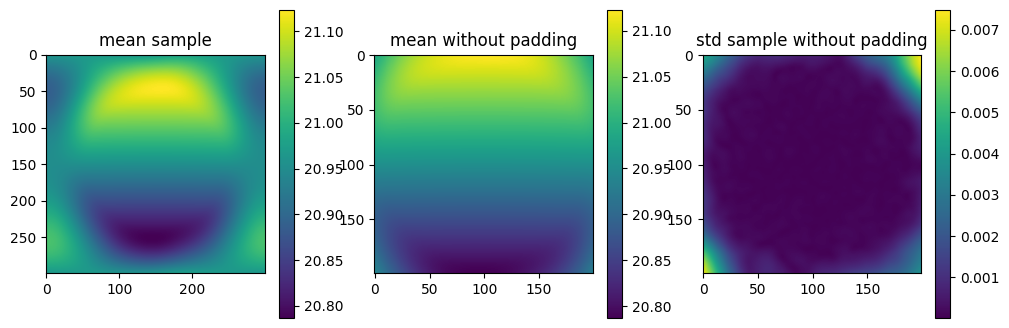

OPTIMIZE_KL: Starting 0015
SL: Iteration 0 ⛰:+1.9792e+18 Δ⛰:inf ➽:9.0003e-07
SL: Iteration 1 ⛰:+1.5020e+18 Δ⛰:4.7715e+17 ➽:9.0003e-07
SL: Iteration 2 ⛰:+6.1089e+17 Δ⛰:8.9114e+17 ➽:9.0003e-07
SL: Iteration 3 ⛰:+2.5455e+17 Δ⛰:3.5634e+17 ➽:9.0003e-07
SL: Iteration 4 ⛰:+1.2775e+17 Δ⛰:1.2681e+17 ➽:9.0003e-07
SL: Iteration 5 ⛰:+5.3603e+16 Δ⛰:7.4144e+16 ➽:9.0003e-07
SL: Iteration 6 ⛰:+2.0863e+16 Δ⛰:3.2740e+16 ➽:9.0003e-07
SL: Iteration 7 ⛰:+1.6150e+16 Δ⛰:4.7135e+15 ➽:9.0003e-07
SL: Iteration 8 ⛰:+7.1865e+15 Δ⛰:8.9631e+15 ➽:9.0003e-07
SL: Iteration 9 ⛰:+7.0142e+15 Δ⛰:1.7232e+14 ➽:9.0003e-07
SL: Iteration 10 ⛰:+1.2868e+15 Δ⛰:5.7274e+15 ➽:9.0003e-07
SL: Iteration 11 ⛰:+1.0125e+15 Δ⛰:2.7426e+14 ➽:9.0003e-07
SL: Iteration 12 ⛰:+1.0057e+15 Δ⛰:6.7880e+12 ➽:9.0003e-07
SL: Iteration 13 ⛰:+8.1391e+14 Δ⛰:1.9183e+14 ➽:9.0003e-07
SL: Iteration 14 ⛰:+7.8445e+14 Δ⛰:2.9463e+13 ➽:9.0003e-07
SL: Iteration 15 ⛰:+7.7072e+14 Δ⛰:1.3730e+13 ➽:9.0003e-07
SL: Iteration 16 ⛰:+6.7787e+14 Δ⛰:9.2849e+13 ➽:9.0003e-07
SL: 

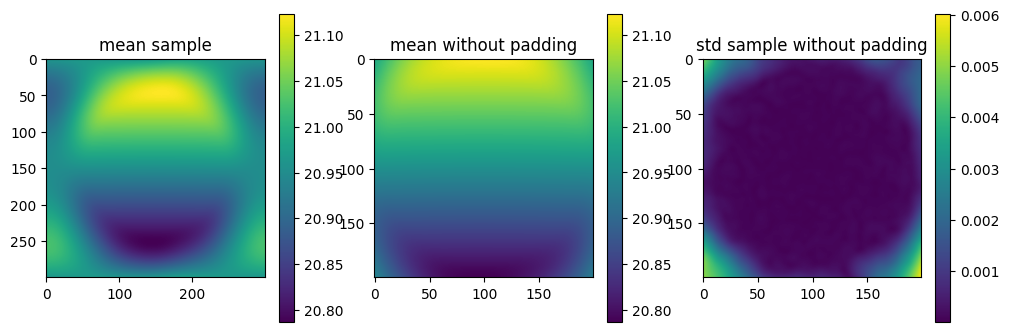

OPTIMIZE_KL: Starting 0016
SL: Iteration 0 ⛰:+7.4385e+18 Δ⛰:inf ➽:9.0003e-07
SL: Iteration 1 ⛰:+3.2093e+18 Δ⛰:4.2293e+18 ➽:9.0003e-07
SL: Iteration 2 ⛰:+1.5246e+17 Δ⛰:3.0568e+18 ➽:9.0003e-07
SL: Iteration 3 ⛰:+3.7513e+16 Δ⛰:1.1495e+17 ➽:9.0003e-07
SL: Iteration 4 ⛰:+3.1588e+16 Δ⛰:5.9242e+15 ➽:9.0003e-07
SL: Iteration 5 ⛰:+1.2726e+16 Δ⛰:1.8862e+16 ➽:9.0003e-07
SL: Iteration 6 ⛰:+9.6552e+15 Δ⛰:3.0711e+15 ➽:9.0003e-07
SL: Iteration 7 ⛰:+4.3606e+15 Δ⛰:5.2947e+15 ➽:9.0003e-07
SL: Iteration 8 ⛰:+4.1104e+15 Δ⛰:2.5015e+14 ➽:9.0003e-07
SL: Iteration 9 ⛰:+3.5170e+15 Δ⛰:5.9338e+14 ➽:9.0003e-07
SL: Iteration 10 ⛰:+1.7418e+15 Δ⛰:1.7753e+15 ➽:9.0003e-07
SL: Iteration 11 ⛰:+1.2803e+15 Δ⛰:4.6145e+14 ➽:9.0003e-07
SL: Iteration 12 ⛰:+1.2265e+15 Δ⛰:5.3792e+13 ➽:9.0003e-07
SL: Iteration 13 ⛰:+8.2634e+14 Δ⛰:4.0019e+14 ➽:9.0003e-07
SL: Iteration 14 ⛰:+8.2617e+14 Δ⛰:1.6824e+11 ➽:9.0003e-07
SL: Iteration 15 ⛰:+8.2406e+14 Δ⛰:2.1120e+12 ➽:9.0003e-07
SL: Iteration 16 ⛰:+5.0619e+14 Δ⛰:3.1787e+14 ➽:9.0003e-07
SL: 

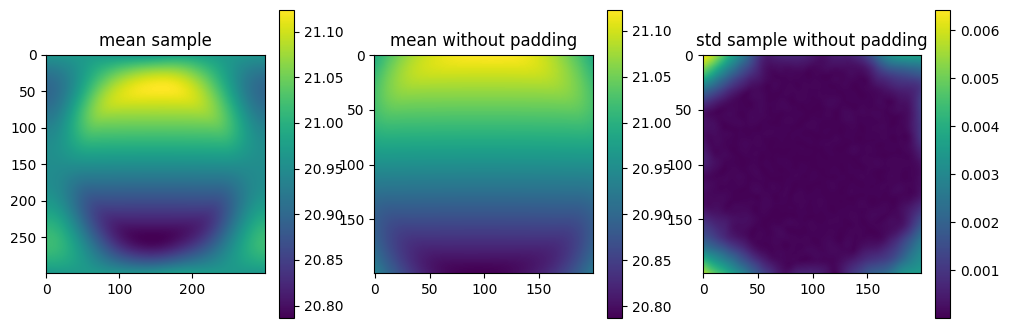

OPTIMIZE_KL: Starting 0017
SL: Iteration 0 ⛰:+5.4742e+18 Δ⛰:inf ➽:9.0003e-07
SL: Iteration 1 ⛰:+2.9089e+18 Δ⛰:2.5653e+18 ➽:9.0003e-07
SL: Iteration 2 ⛰:+1.6037e+17 Δ⛰:2.7486e+18 ➽:9.0003e-07
SL: Iteration 3 ⛰:+8.9215e+16 Δ⛰:7.1155e+16 ➽:9.0003e-07
SL: Iteration 4 ⛰:+4.2576e+16 Δ⛰:4.6639e+16 ➽:9.0003e-07
SL: Iteration 5 ⛰:+2.9125e+16 Δ⛰:1.3451e+16 ➽:9.0003e-07
SL: Iteration 6 ⛰:+1.0277e+16 Δ⛰:1.8848e+16 ➽:9.0003e-07
SL: Iteration 7 ⛰:+5.6323e+15 Δ⛰:4.6448e+15 ➽:9.0003e-07
SL: Iteration 8 ⛰:+4.7316e+15 Δ⛰:9.0078e+14 ➽:9.0003e-07
SL: Iteration 9 ⛰:+4.1477e+15 Δ⛰:5.8388e+14 ➽:9.0003e-07
SL: Iteration 10 ⛰:+1.4691e+15 Δ⛰:2.6786e+15 ➽:9.0003e-07
SL: Iteration 11 ⛰:+1.3249e+15 Δ⛰:1.4420e+14 ➽:9.0003e-07
SL: Iteration 12 ⛰:+1.0156e+15 Δ⛰:3.0930e+14 ➽:9.0003e-07
SL: Iteration 13 ⛰:+7.6558e+14 Δ⛰:2.4999e+14 ➽:9.0003e-07
SL: Iteration 14 ⛰:+7.6519e+14 Δ⛰:3.9232e+11 ➽:9.0003e-07
SL: Iteration 15 ⛰:+6.1780e+14 Δ⛰:1.4739e+14 ➽:9.0003e-07
SL: Iteration 16 ⛰:+6.1580e+14 Δ⛰:1.9951e+12 ➽:9.0003e-07
SL: 

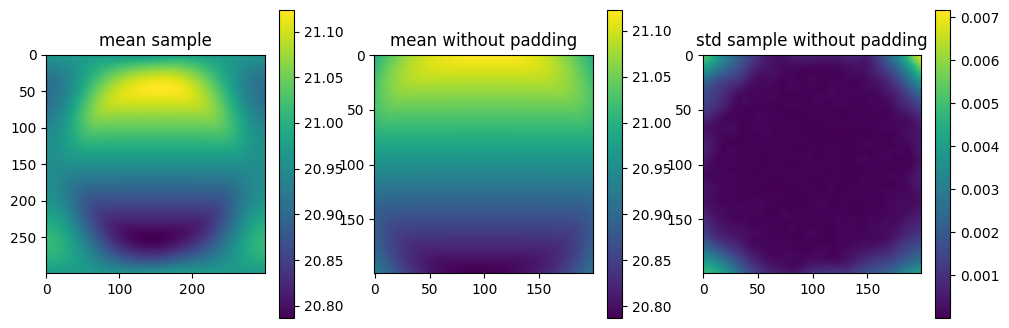

OPTIMIZE_KL: Starting 0018
SL: Iteration 0 ⛰:+1.4484e+19 Δ⛰:inf ➽:9.0003e-07
SL: Iteration 1 ⛰:+2.5633e+18 Δ⛰:1.1921e+19 ➽:9.0003e-07
SL: Iteration 2 ⛰:+1.1532e+17 Δ⛰:2.4479e+18 ➽:9.0003e-07
SL: Iteration 3 ⛰:+7.3362e+16 Δ⛰:4.1958e+16 ➽:9.0003e-07
SL: Iteration 4 ⛰:+4.1095e+16 Δ⛰:3.2267e+16 ➽:9.0003e-07
SL: Iteration 5 ⛰:+2.5355e+16 Δ⛰:1.5740e+16 ➽:9.0003e-07
SL: Iteration 6 ⛰:+1.3098e+16 Δ⛰:1.2257e+16 ➽:9.0003e-07
SL: Iteration 7 ⛰:+7.8041e+15 Δ⛰:5.2938e+15 ➽:9.0003e-07
SL: Iteration 8 ⛰:+7.4417e+15 Δ⛰:3.6242e+14 ➽:9.0003e-07
SL: Iteration 9 ⛰:+4.7496e+15 Δ⛰:2.6921e+15 ➽:9.0003e-07
SL: Iteration 10 ⛰:+2.7447e+15 Δ⛰:2.0049e+15 ➽:9.0003e-07
SL: Iteration 11 ⛰:+2.0124e+15 Δ⛰:7.3230e+14 ➽:9.0003e-07
SL: Iteration 12 ⛰:+1.4884e+15 Δ⛰:5.2396e+14 ➽:9.0003e-07
SL: Iteration 13 ⛰:+8.9918e+14 Δ⛰:5.8926e+14 ➽:9.0003e-07
SL: Iteration 14 ⛰:+8.9822e+14 Δ⛰:9.6069e+11 ➽:9.0003e-07
SL: Iteration 15 ⛰:+7.8817e+14 Δ⛰:1.1005e+14 ➽:9.0003e-07
SL: Iteration 16 ⛰:+7.8599e+14 Δ⛰:2.1837e+12 ➽:9.0003e-07
SL: 

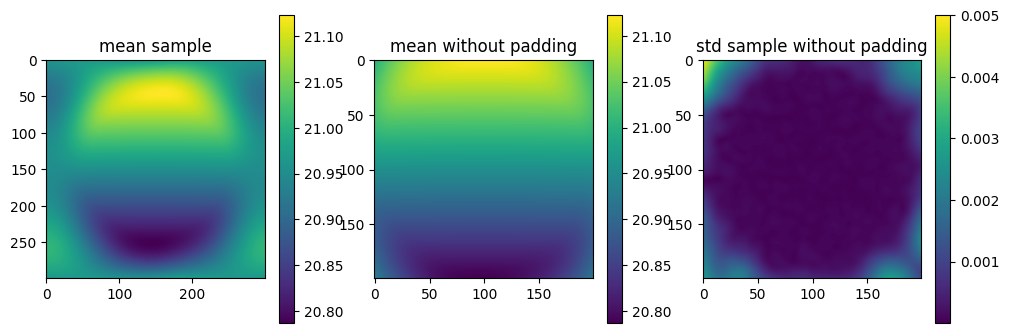

OPTIMIZE_KL: Starting 0019
SL: Iteration 0 ⛰:+4.9480e+18 Δ⛰:inf ➽:9.0003e-07
SL: Iteration 1 ⛰:+3.4435e+18 Δ⛰:1.5044e+18 ➽:9.0003e-07
SL: Iteration 2 ⛰:+8.1894e+17 Δ⛰:2.6246e+18 ➽:9.0003e-07
SL: Iteration 3 ⛰:+6.1638e+16 Δ⛰:7.5731e+17 ➽:9.0003e-07
SL: Iteration 4 ⛰:+5.0124e+16 Δ⛰:1.1514e+16 ➽:9.0003e-07
SL: Iteration 5 ⛰:+2.6994e+16 Δ⛰:2.3130e+16 ➽:9.0003e-07
SL: Iteration 6 ⛰:+1.3544e+16 Δ⛰:1.3449e+16 ➽:9.0003e-07
SL: Iteration 7 ⛰:+4.9830e+15 Δ⛰:8.5612e+15 ➽:9.0003e-07
SL: Iteration 8 ⛰:+3.3055e+15 Δ⛰:1.6775e+15 ➽:9.0003e-07
SL: Iteration 9 ⛰:+3.2955e+15 Δ⛰:1.0013e+13 ➽:9.0003e-07
SL: Iteration 10 ⛰:+2.1326e+15 Δ⛰:1.1629e+15 ➽:9.0003e-07
SL: Iteration 11 ⛰:+1.3508e+15 Δ⛰:7.8177e+14 ➽:9.0003e-07
SL: Iteration 12 ⛰:+1.3282e+15 Δ⛰:2.2607e+13 ➽:9.0003e-07
SL: Iteration 13 ⛰:+1.1420e+15 Δ⛰:1.8615e+14 ➽:9.0003e-07
SL: Iteration 14 ⛰:+7.3589e+14 Δ⛰:4.0614e+14 ➽:9.0003e-07
SL: Iteration 15 ⛰:+7.1369e+14 Δ⛰:2.2198e+13 ➽:9.0003e-07
SL: Iteration 16 ⛰:+5.7407e+14 Δ⛰:1.3962e+14 ➽:9.0003e-07
SL: 

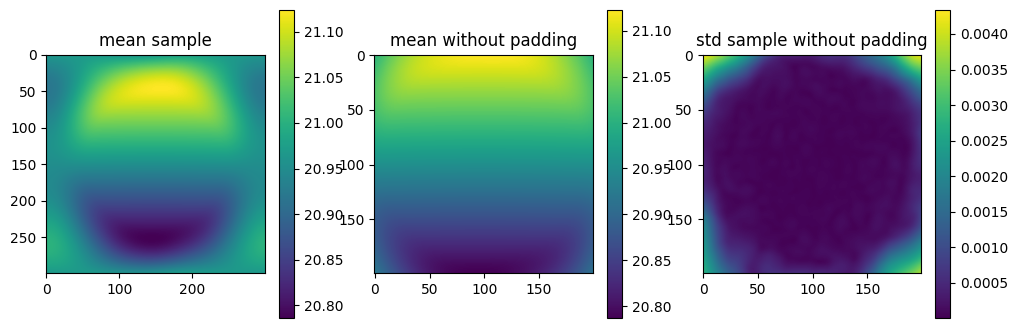

OPTIMIZE_KL: Starting 0020
SL: Iteration 0 ⛰:+1.6091e+19 Δ⛰:inf ➽:9.0003e-07
SL: Iteration 1 ⛰:+9.6521e+17 Δ⛰:1.5125e+19 ➽:9.0003e-07
SL: Iteration 2 ⛰:+2.8685e+17 Δ⛰:6.7835e+17 ➽:9.0003e-07
SL: Iteration 3 ⛰:+4.9878e+16 Δ⛰:2.3698e+17 ➽:9.0003e-07
SL: Iteration 4 ⛰:+2.9558e+16 Δ⛰:2.0320e+16 ➽:9.0003e-07
SL: Iteration 5 ⛰:+1.0289e+16 Δ⛰:1.9269e+16 ➽:9.0003e-07
SL: Iteration 6 ⛰:+5.3476e+15 Δ⛰:4.9414e+15 ➽:9.0003e-07
SL: Iteration 7 ⛰:+2.8695e+15 Δ⛰:2.4782e+15 ➽:9.0003e-07
SL: Iteration 8 ⛰:+2.7523e+15 Δ⛰:1.1713e+14 ➽:9.0003e-07
SL: Iteration 9 ⛰:+2.0859e+15 Δ⛰:6.6646e+14 ➽:9.0003e-07
SL: Iteration 10 ⛰:+1.1020e+15 Δ⛰:9.8384e+14 ➽:9.0003e-07
SL: Iteration 11 ⛰:+7.2765e+14 Δ⛰:3.7437e+14 ➽:9.0003e-07
SL: Iteration 12 ⛰:+7.1569e+14 Δ⛰:1.1960e+13 ➽:9.0003e-07
SL: Iteration 13 ⛰:+5.5300e+14 Δ⛰:1.6269e+14 ➽:9.0003e-07
SL: Iteration 14 ⛰:+5.5247e+14 Δ⛰:5.3194e+11 ➽:9.0003e-07
SL: Iteration 15 ⛰:+5.3207e+14 Δ⛰:2.0395e+13 ➽:9.0003e-07
SL: Iteration 16 ⛰:+4.5632e+14 Δ⛰:7.5747e+13 ➽:9.0003e-07
SL: 

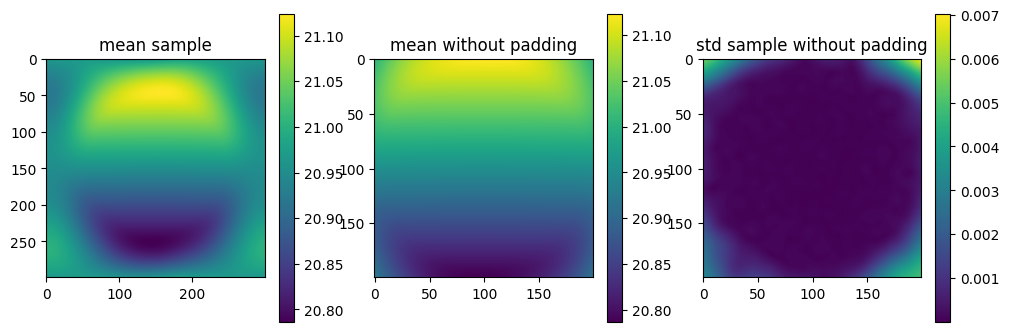

In [25]:
# n_it = 1
n_it = 20
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-10
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4
n_samples = 4 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    mean, std = jft.mean_and_std(tuple(gp_map(s) for s in samples))
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    im0 = axes[0].imshow(mean)
    axes[0].title.set_text('mean sample')
    fig.colorbar(im0)
    
    im1 = axes[1].imshow(mean[padding//2:-padding//2, padding//2:-padding//2])
    axes[1].title.set_text('mean without padding')
    fig.colorbar(im1)

    im2 = axes[2].imshow(std[padding//2:-padding//2, padding//2:-padding//2])
    axes[2].title.set_text('std sample without padding')
    fig.colorbar(im2)
    
    plt.show()

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
        # cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=10),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=10
        )
    ),
    # sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    sample_mode = lambda x: "nonlinear_resample" if x >= 1 else "linear_resample",
    callback=callback,
)

In [26]:
printfitresults()

Fit Results (res, init, std)
fluctuations: 0.014838067214475626, 0.16871608827074525, 0.033743217654149046
loglogvarslope: -6.589618504523393, -10.0, 5.0
zeromode: 15.324337342169208, 20.95525829052564, 0.698508609684188


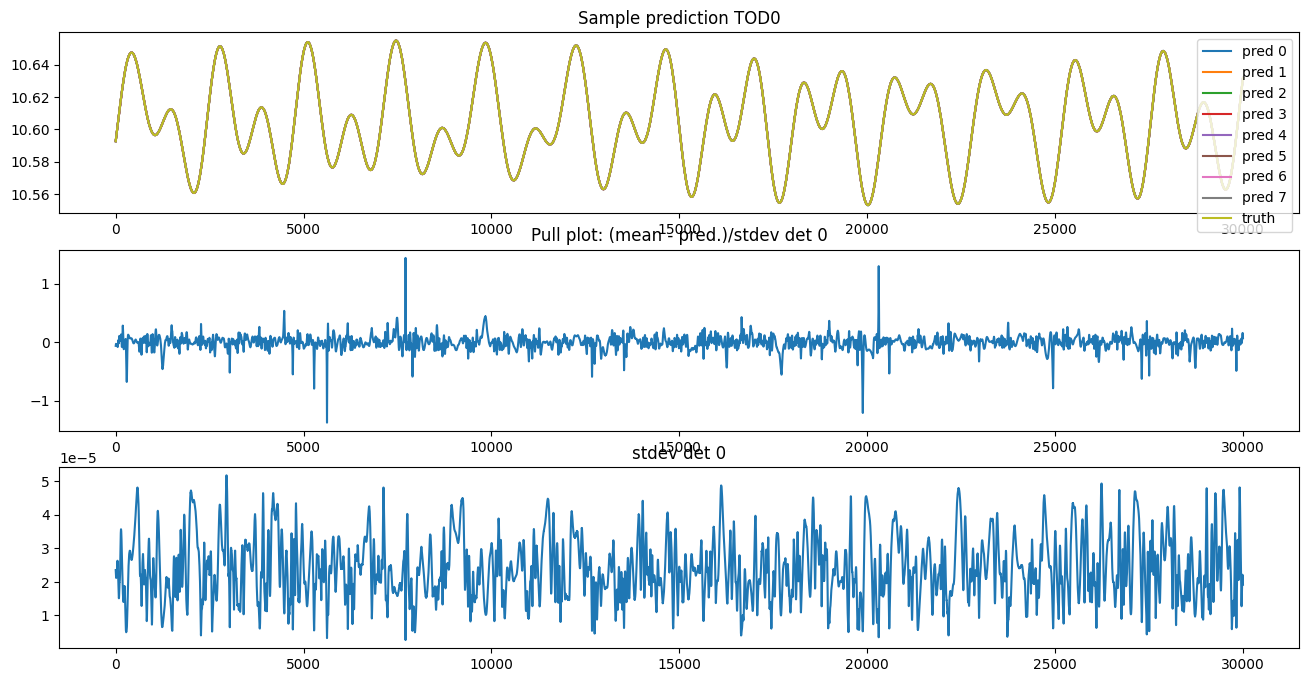

In [27]:
# plot time-series for det 0 for all samples:
fig, axes = plt.subplots(3, 1, figsize=(16, 8))

mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

i = 0
for s in samples:

    axes[0].plot(signal_response_tod(s)[0], label=f"pred {i}")
    # axes[1].plot((signal_response_tod(s)[0] - jax_tods[0])/std[0], label=i)
    i += 1

axes[0].plot(jax_tods[0], label="truth")
axes[0].set_title("Sample prediction TOD0")
axes[0].legend()

# axes[1].plot(jax_tods[0])
axes[1].plot((mean[0] - jax_tods[0])/std[0])
axes[1].set_title(f"Pull plot: (mean - pred.)/stdev det 0")

axes[2].plot(std[0])
axes[2].set_title(f"stdev det 0")

plt.show()

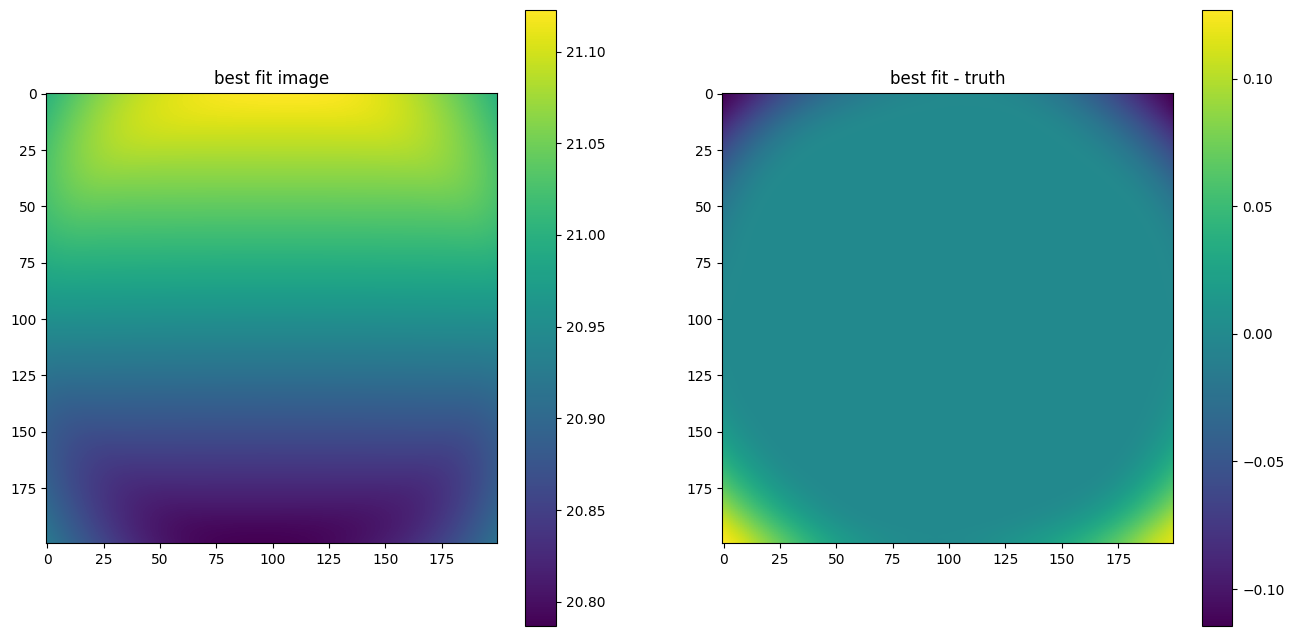

In [28]:
# plot maximum of posterior (mode)
# sig_map = signal_response(samples.pos) # gives time-series
sig_map = gp_map(samples.pos) # when splitting up in different field models

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(sig_map[padding//2:-padding//2, padding//2:-padding//2])
# im0 = axes[0].imshow(sig_map)
axes[0].title.set_text('best fit image')
fig.colorbar(im0)

im1 = axes[1].imshow( sig_map[padding//2:-padding//2, padding//2:-padding//2] - atmosdata_truth)
# im1 = axes[1].imshow( sig_map - atmosdata_truth)
axes[1].title.set_text('best fit - truth')
# im1 = axes[1].imshow( (sig_map - mapdata_truth) )
# axes[1].title.set_text('diff prediction - map truth')
fig.colorbar(im1)

plt.show()

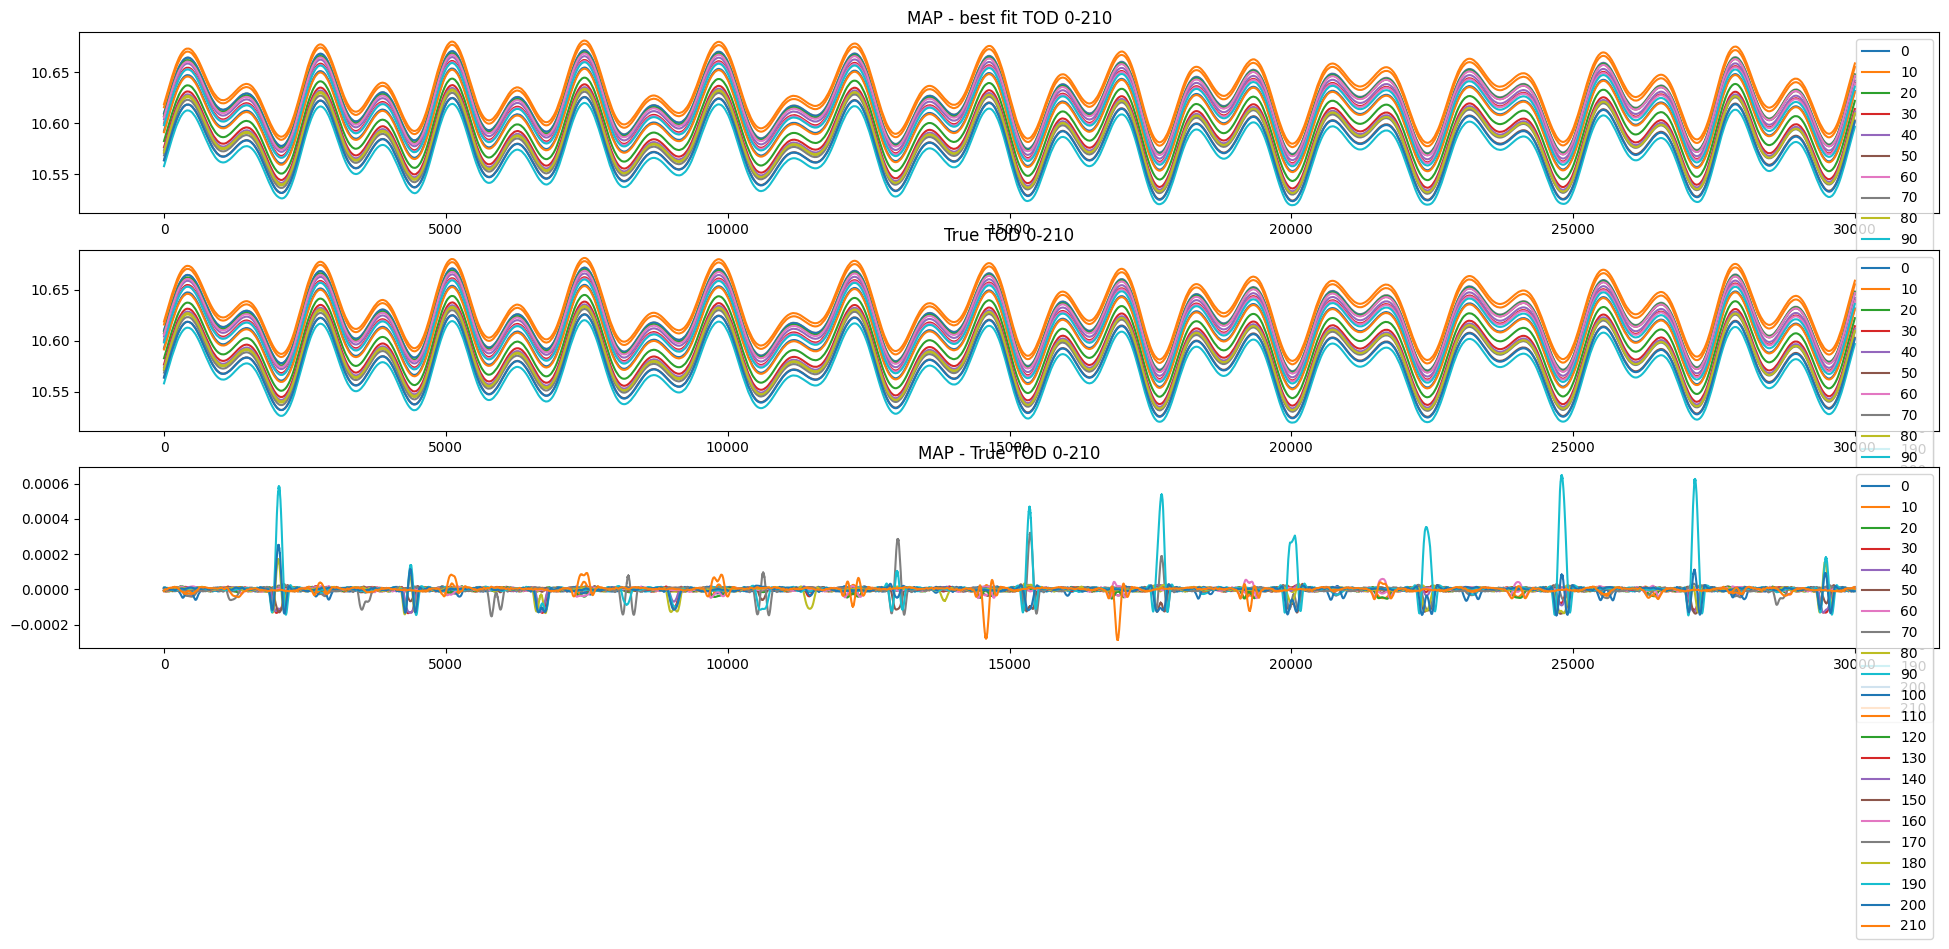

In [29]:
# plot maximum of posterior (mode)
pred_tods = signal_response_tod(samples.pos) # gives time-series

fig, axes = plt.subplots(3, 1, figsize=(8*3, 8))

# for i in [0, 10, 100, 200]:
for i in range(0, len(jax_tods), len(jax_tods)//20):
    im0 = axes[0].plot(pred_tods[i], label=i)
    # im1 = axes[1].plot(tods_map[i], label=i)
    im1 = axes[1].plot(jax_tods[i], label=i)
    im2 = axes[2].plot(pred_tods[i] - jax_tods[i], label=i)
    
axes[0].title.set_text(f'MAP - best fit TOD 0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True TOD 0-{i}')
axes[1].legend()
axes[2].title.set_text(f'MAP - True TOD 0-{i}')
axes[2].legend()

plt.show()